# XGBoost based prediction of antibiotic resistance in Enterobacterales BSI

## Import libraries

In [1401]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, precision_recall_curve, roc_curve
from sklearn.calibration import CalibratedClassifierCV
import xgboost as xgb

# hyperparameter tuning
from hyperopt import tpe, Trials, hp, fmin, STATUS_OK, space_eval

import matplotlib.pyplot as plt
import shap


## Functions

### Loading data

In [1402]:
def strip_columns(df, species=0):
    '''Remove columns that aren't needed for analysis'''
    out = df
    info_columns = [c for c in out.columns if 'INFO' in c]
    outcome_columns = [c for c in out.columns if 'OUTCOME' in c]
    remove_other_columns = ['pt','index_dt']
    return out.drop(columns=info_columns + outcome_columns + remove_other_columns)

In [1403]:
def bug_grouper(bugname):
    '''Group bug names into categories'''
    # group bug names
    bugname = bugname.lower()
    if "escherichia coli" in bugname: return "Escherichia coli"
    if "klebsiella" in bugname: return "Klebsiella spp."
    if "enterobacter" in bugname: return "Enterobacter spp."
    if "citrobacter" in bugname: return "Citrobacter spp."
    if "serratia" in bugname: return "Serratia spp."
    if "proteus" in bugname or "providencia" in bugname or "morganella" in bugname: return "Proteus Providencia Morganella spp."
    else: return "Other"

In [1404]:
def onehot_encode(df, species=0):
    '''One hot encode categorical columns'''
    
    if species == 1:
        # apply bug grouper
        df['bug_group'] = df['INFO_bugname'].apply(bug_grouper)
        categorical_cols = ['bug_group', 'DEMOGRAPHICS_sex','SPECIALTY_current_spec',
                        'PREV_HOSP_STAY_adm_type']
    else:
        categorical_cols = ['DEMOGRAPHICS_sex','SPECIALTY_current_spec',
                        'PREV_HOSP_STAY_adm_type']
    
    # replace PREV_HOSP_STAY_adm_type==Outpatient with 'Other'
    df['PREV_HOSP_STAY_adm_type'] = np.where(df['PREV_HOSP_STAY_adm_type'] == 'Outpatient', 'Other', df['PREV_HOSP_STAY_adm_type'])
       
    df = pd.get_dummies(df, columns = categorical_cols)
    
    # drop specific categories to make them the reference category
    df.drop(columns=['SPECIALTY_current_spec_Acute, emergency and geriatric medicine'], inplace=True)
    df.drop(columns=['PREV_HOSP_STAY_adm_type_Emergency'], inplace=True)
    df.drop(columns=['DEMOGRAPHICS_sex_F'], inplace=True)
    if species == 1:
        df.drop(columns=['bug_group_Escherichia coli'], inplace=True)
    
    return df

In [1405]:
def load_data(file, species=0):
    df = pd.read_csv(file)
    print(df.columns)
    print(df.shape)
    
    # set up outcome variable
    df['y'] = np.where(df['OUTCOME_ast_result'] == 'R', 1, 0)
    
    #one hot encoding
    df = onehot_encode(df, species)
    
    # add a noise variable with random numbers
    #df['noise'] = np.random.rand(df.shape[0])
    
    # split data by index date
    df['index_dt'] = pd.to_datetime(df['index_dt'])
    
    # use dates from 01 Jan 2017 to 31 Dec 2021 for training
    df_train_raw = df[(df['index_dt'] >= '2017-01-01') & (df['index_dt'] < '2022-01-01')]
    df_train_extended_raw = df[(df['index_dt'] >= '2017-01-01') & (df['index_dt'] < '2023-01-01')]
    
    # create two test sets from 01 Jan 2022 to 31 Dec 2022 and 01 Jan 2023 to 31 Dec 2023
    df_test1_raw = df[(df['index_dt'] >= '2022-01-01') & (df['index_dt'] < '2023-01-01')]
    df_test2_raw = df[(df['index_dt'] >= '2023-01-01') & (df['index_dt'] < '2024-01-01')]  
    
    # remove index date
    df_train = strip_columns(df_train_raw)
    df_train_extended = strip_columns(df_train_extended_raw)
    df_test1 = strip_columns(df_test1_raw)
    df_test2 = strip_columns(df_test2_raw)
    
    # set up data frames for modelling for training and test sets
    X_train = df_train.drop(columns=['y'])
    y_train = df_train['y']
    X_train_extended = df_train_extended.drop(columns=['y'])
    y_train_extended = df_train_extended['y']
    
    X_test1 = df_test1.drop(columns=['y'])
    y_test1 = df_test1['y']
    X_test2 = df_test2.drop(columns=['y'])
    y_test2 = df_test2['y']
    
    print(X_train.shape, len(y_train), sum(y_train))
    print(X_train_extended.shape, len(y_train_extended), sum(y_train_extended))
    print(X_test1.shape, len(y_test1), sum(y_test1))
    print(X_test2.shape, len(y_test2), sum(y_test2))
    
    return (y_train, X_train, y_train_extended, X_train_extended, y_test1, X_test1, y_test2, X_test2, X_train.columns, df_train_raw, 
            df_train_extended_raw, df_test1_raw, df_test2_raw)

### output reporting

In [1406]:
def custom_classification_report(y_true, y_pred, y_prob):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    acc = (tp+tn)/(tp+tn+fp+fn)
    sen = (tp)/(tp+fn)
    sp = (tn)/(tn+fp)
    bal_acc = (sen+sp)/2
    ppv = (tp)/(tp+fp)
    npv = (tn)/(tn+fn)
    f1 = 2*(sen*ppv)/(sen+ppv)
    fpr = (fp)/(fp+tn)
    tpr = (tp)/(tp+fn)
    return (    '2X2 confusion matrix:', ['TP', tp, 'FP', fp, 'FN', fn, 'TN', tn],
                'Accuracy:', round(acc, 3),
                'Balanced accuracy:', round(bal_acc, 3),
                'Sensitivity/Recall:', round(sen, 3),
                'Specificity:', round(sp, 3),
                'PPV/Precision:', round(ppv, 3),
                'NPV:', round(npv, 3),
                'F1-score:', round(f1, 3),
                'False positive rate:', round(fpr, 3),
                'True positive rate:', round(tpr, 3),
                'ROC AUC:', round(roc_auc_score(y_true, y_prob), 3)
            )

In [1407]:
def summary_report(xgb_model, test_x, test_y, train_x, train_y):
    print('Baseline model performance (train):')
    pred_y_train = xgb_model.predict(train_x)
    prob_y_train = xgb_model.predict_proba(train_x)[:,1]
    print(custom_classification_report(train_y, pred_y_train, prob_y_train))
    print('Baseline model performance (test):')
    pred_y_test = xgb_model.predict(test_x)
    prob_y_test = xgb_model.predict_proba(test_x)[:,1]
    print(custom_classification_report(test_y, pred_y_test, prob_y_test))
    print('Confusion matrix:')
    ConfusionMatrixDisplay.from_predictions(test_y, pred_y_test)
    plt.show()

In [1408]:
def scale_pos_weight(train_y):
    wt = (len(train_y) - sum(train_y)) / sum(train_y)
    print('Scale pos weight:', wt)
    return wt

In [1409]:
def baseline_model(train_x, train_y, test_x, test_y, scale_pos_weight):
    xgb_baseline = xgb.XGBClassifier(scale_pos_weight=scale_pos_weight, seed=0)
    xgb_baseline.fit(train_x, train_y)
    summary_report(xgb_baseline, test_x, test_y, train_x, train_y)
    return xgb_baseline

In [1410]:
# Set up the k-fold cross-validation
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
#kfold = StratifiedKFold(n_splits=5, shuffle=False)

# Objective function
def objective(params):
    xgboost = xgb.XGBClassifier(scale_pos_weight=scale_pos_weight, seed=42, **params)
    score = cross_val_score(estimator=xgboost,
                            X=train_x,
                            y=train_y,
                            cv=kfold,
                            scoring = 'roc_auc', # may be less good if unbalanced
                            #scoring='f1',
                            #scoring = 'balanced_accuracy', #use f1 if priority is detecting positves, if also care more about TN then use balanced accuracy
                            #scoring = 'recall', #favour sensitivity over specificity
                            n_jobs=-1).mean()
    # Loss is negative score
    loss = -score
    # Dictionary with information for evaluation
    return {'loss': loss, 'params': params, 'status': STATUS_OK}

# function to optimize
def optimized_model(train_x, train_y, test_x, test_y, scale_pos_weight, trials, max_evals, abx, species=0):
    if abx in ['amoxicillin', 'co-amoxiclav', 'co-trimoxazole']:
        space = {
        'n_estimators': hp.choice('n_estimators', range(50, 1500, 20)), 
        'learning_rate': hp.choice('learning_rate', [0.0001, 0.0002, 0.0005, 0.001, 0.002, 0.005]),
        'max_depth' : hp.choice('max_depth', range(3,12,1)),
        'gamma' : hp.choice('gamma', range(1,20,1)),
         'min_child_weight' : hp.choice('min_child_weight', range(2,20,1)),
        'colsample_bytree' : hp.choice('colsample_bytree', [i/20.0 for i in range(1,16)]),
        'subsample' : hp.choice('subsample', [i/20.0 for i in range(1,16)])
        }
    else:
        space = {
        'n_estimators': hp.choice('n_estimators', range(50, 800, 20)), 
        'learning_rate': hp.choice('learning_rate', [0.0001, 0.0002, 0.0005, 0.001, 0.002, 0.005]),
        'max_depth' : hp.choice('max_depth', range(3,6,1)),
        'gamma' : hp.choice('gamma', range(3,20,1)),
         'min_child_weight' : hp.choice('min_child_weight', range(3,20,1)),
        'colsample_bytree' : hp.choice('colsample_bytree', [i/20.0 for i in range(1,16)]),
        'subsample' : hp.choice('subsample', [i/20.0 for i in range(1,16)])
        }
    
    
    
    best = fmin(fn = objective, space = space, algo = tpe.suggest, max_evals = max_evals, trials = trials)
    # Print the values of the best parameters
    print(space_eval(space, best))
    # save the values of best parameters to csv 
    df_param = pd.DataFrame.from_dict(space_eval(space, best), orient="index")
    # change column names
    df_param = df_param.transpose()
    df_param['antibiotic'] = abx
    df_param['species'] = species
    if species == 1:
        df_param.to_csv('data/best_hyperparams_species_%s.csv'%abx, index=False)
    else:
        df_param.to_csv('data/best_hyperparams_%s.csv'%abx, index=False)
    
    # Train model using the best parameters
    xgb_optim = xgb.XGBClassifier(seed=42,
                               scale_pos_weight=scale_pos_weight,
                               n_estimators=space_eval(space, best)['n_estimators'],
                               colsample_bytree=space_eval(space, best)['colsample_bytree'],
                               subsample=space_eval(space, best)['subsample'],
                               gamma=space_eval(space, best)['gamma'],
                               min_child_weight=space_eval(space, best)['min_child_weight'],
                               learning_rate=space_eval(space, best)['learning_rate'],
                               max_depth=space_eval(space, best)['max_depth']#,
                               #reg_alpha=space_eval(space, best)['reg_alpha'],
                               #reg_lambda=space_eval(space, best)['reg_lambda']
                               ).fit(train_x, train_y)
    summary_report(xgb_optim, test_x, test_y, train_x, train_y)
    return xgb_optim, space_eval(space, best)

In [1411]:
def feature_importance(xgb_optim, colnames, filename):
    # feature importance
    n_top_features = 100
    sorted_idx = xgb_optim.feature_importances_.argsort()[::-1]
    n_top_features = len(sorted_idx)
    fImportance=pd.DataFrame(np.zeros((n_top_features,2)))
    fImportance.columns=['Features', 'Importance']
    fImportance['Features']=colnames[sorted_idx][:n_top_features].tolist()
    fImportance['Importance']=xgb_optim.feature_importances_[sorted_idx][:n_top_features].tolist()
    fImportance.to_csv(filename)    
    return fImportance

In [1412]:
# isotonic regression calibration using all of training data, i.e. cv='prefit'
def iso_reg(xgb_model, train_x, train_y):
    calibrated = CalibratedClassifierCV(xgb_model, method='sigmoid', cv=None)
    calibrated.fit(train_x, train_y)
    return calibrated

In [1413]:
def save_predictions(xgb_optim, test_x, test2_x, train_x, train_y, df_train_raw, df_test1_raw, df_test2_raw, filename,
                     test2_only=0):
    
    # add back in outcome
    out_train = df_train_raw
    out_test1 = df_test1_raw
    out_test2 = df_test2_raw
    
    # for training data
    # get raw predictions
    out_train['pred_y'] = xgb_optim.predict(train_x)
    out_train['prob_y'] = xgb_optim.predict_proba(train_x)[:,1]
    
    # get calibrated predictions
    calibrated = iso_reg(xgb_optim, train_x, train_y)
    out_train['calib_prob_y'] = calibrated.predict_proba(train_x)[:,1]
    
    # get probability threshold that maximises F1 score
    precision, recall, thresholds = precision_recall_curve(train_y, out_train['calib_prob_y'])
    numerator = 2 * recall * precision
    denom = recall + precision
    f1_scores = np.divide(numerator, denom, out=np.zeros_like(denom), where=(denom!=0))
    max_f1 = np.max(f1_scores)
    max_f1_thresh = thresholds[np.argmax(f1_scores)]
    print('Max F1:', max_f1, 'Threshold:', max_f1_thresh)
    
    # get threshold maximising sensivity and specificity
    fpr, tpr, thresholds = roc_curve(train_y, out_train['calib_prob_y'])
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[optimal_idx]
    print('Optimal threshold:', optimal_threshold)
    
    
    # apply threshold to get calibrated predictions
    out_train['calib_pred_y'] = np.where(out_train['calib_prob_y'] > optimal_threshold, 1, 0)
    #out_train['pred_y'] = calibrated.predict(train_x)
    out_train['dataset'] = 'train'
    
    # get predictions for test_x 1
    if test2_only == 0:
        out_test1['prob_y'] = xgb_optim.predict_proba(test_x)[:,1]
        out_test1['pred_y'] = xgb_optim.predict(test_x)
        out_test1['calib_prob_y'] = calibrated.predict_proba(test_x)[:,1]
        #out_test1['calib_pred_y'] = calibrated.predict(test_x)
        out_test1['calib_pred_y'] = np.where(out_test1['calib_prob_y'] > optimal_threshold, 1, 0)
        out_test1['dataset'] = 'test1'
    
    # get predictions for test_x 2
    out_test2['prob_y'] = xgb_optim.predict_proba(test2_x)[:,1]
    out_test2['pred_y'] = xgb_optim.predict(test2_x)
    out_test2['calib_prob_y'] = calibrated.predict_proba(test2_x)[:,1]
    #out_test2['calib_pred_y'] = calibrated.predict(test2_x)
    out_test2['calib_pred_y'] = np.where(out_test2['calib_prob_y'] > optimal_threshold, 1, 0)
    out_test2['dataset'] = 'test2'
    
    if test2_only == 0:
        df_all = pd.concat([out_train, out_test1, out_test2])
    else:   
        df_all = pd.concat([out_train, out_test2])

    df_all.to_csv(filename)

In [1414]:
# get shap feature importance
def shapley_feature_ranking(shap_values, X):
    feature_order = np.argsort(np.mean(np.abs(shap_values), axis=0))
    return pd.DataFrame(
        {
            "features": [X.columns[i] for i in feature_order][::-1],
            "importance": [
                np.mean(np.abs(shap_values), axis=0)[i] for i in feature_order
            ][::-1],
        }
    )


In [1415]:
HYPERPARAMETER_TUNING_MAX_EVALS = 100

## Resistance prediction

In [1416]:
# column nice name mapper
# read in column mapping CSV
col_map = pd.read_csv('column_mapper.csv', index_col=0)
# drop new_name_group column
col_map.drop(columns=['new_name_group', 'new_name_stem'], inplace=True)
# convert to dictionary
COLUMNS_NAME_MAP = col_map.to_dict()['new_name']

amoxicillin
Index(['pt', 'index_dt', 'INFO_accessionnumber', 'INFO_bugname',
       'INFO_antibiotic', 'OUTCOME_ast_result', 'INFO_index_dt_since_baseline',
       'INDEX_DATE_index_dt_hour', 'INFO_BASELINE_ABX_baseline_abx',
       'INFO_BASELINE_ABX_last_betalactam',
       ...
       'MICRO_micro_sample_time_last_urine_365d',
       'MICRO_micro_sample_time_last_blood_365d',
       'MICRO_micro_positive_any_species_count_urine_365d',
       'MICRO_micro_positive_time_last_urine_365d',
       'MICRO_micro_positive_any_species_count_blood_365d',
       'MICRO_micro_positive_time_last_blood_365d',
       'MICRO_micro_positive_specific_species_count_urine_365d',
       'MICRO_micro_positive_specific_species_time_last_urine_365d',
       'MICRO_micro_positive_specific_species_count_blood_365d',
       'MICRO_micro_positive_specific_species_time_last_blood_365d'],
      dtype='object', length=156)
(4664, 156)
(3260, 152) 3260 2193
(3953, 152) 3953 2648
(693, 152) 693 455
(711, 152) 711 45

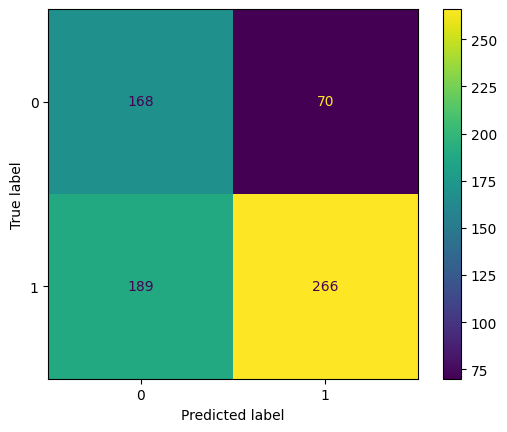

Time taken in seconds: 65
Test set 2
Baseline model performance (train):
('2X2 confusion matrix:', ['TP', np.int64(1280), 'FP', np.int64(231), 'FN', np.int64(913), 'TN', np.int64(836)], 'Accuracy:', np.float64(0.649), 'Balanced accuracy:', np.float64(0.684), 'Sensitivity/Recall:', np.float64(0.584), 'Specificity:', np.float64(0.784), 'PPV/Precision:', np.float64(0.847), 'NPV:', np.float64(0.478), 'F1-score:', np.float64(0.691), 'False positive rate:', np.float64(0.216), 'True positive rate:', np.float64(0.584), 'ROC AUC:', np.float64(0.744))
Baseline model performance (test):
('2X2 confusion matrix:', ['TP', np.int64(243), 'FP', np.int64(67), 'FN', np.int64(216), 'TN', np.int64(185)], 'Accuracy:', np.float64(0.602), 'Balanced accuracy:', np.float64(0.632), 'Sensitivity/Recall:', np.float64(0.529), 'Specificity:', np.float64(0.734), 'PPV/Precision:', np.float64(0.784), 'NPV:', np.float64(0.461), 'F1-score:', np.float64(0.632), 'False positive rate:', np.float64(0.266), 'True positive ra

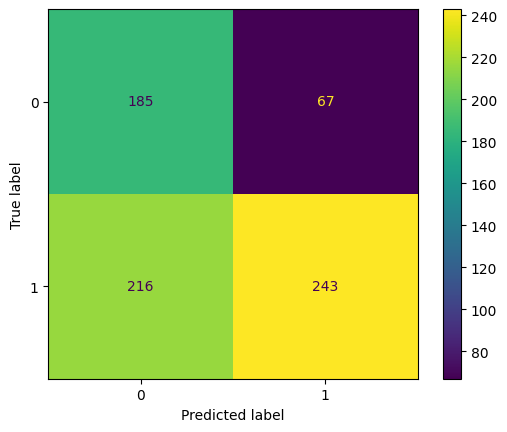

Max F1: 0.8117624298703813 Threshold: 0.48563866618992746
Optimal threshold: 0.647630010318892


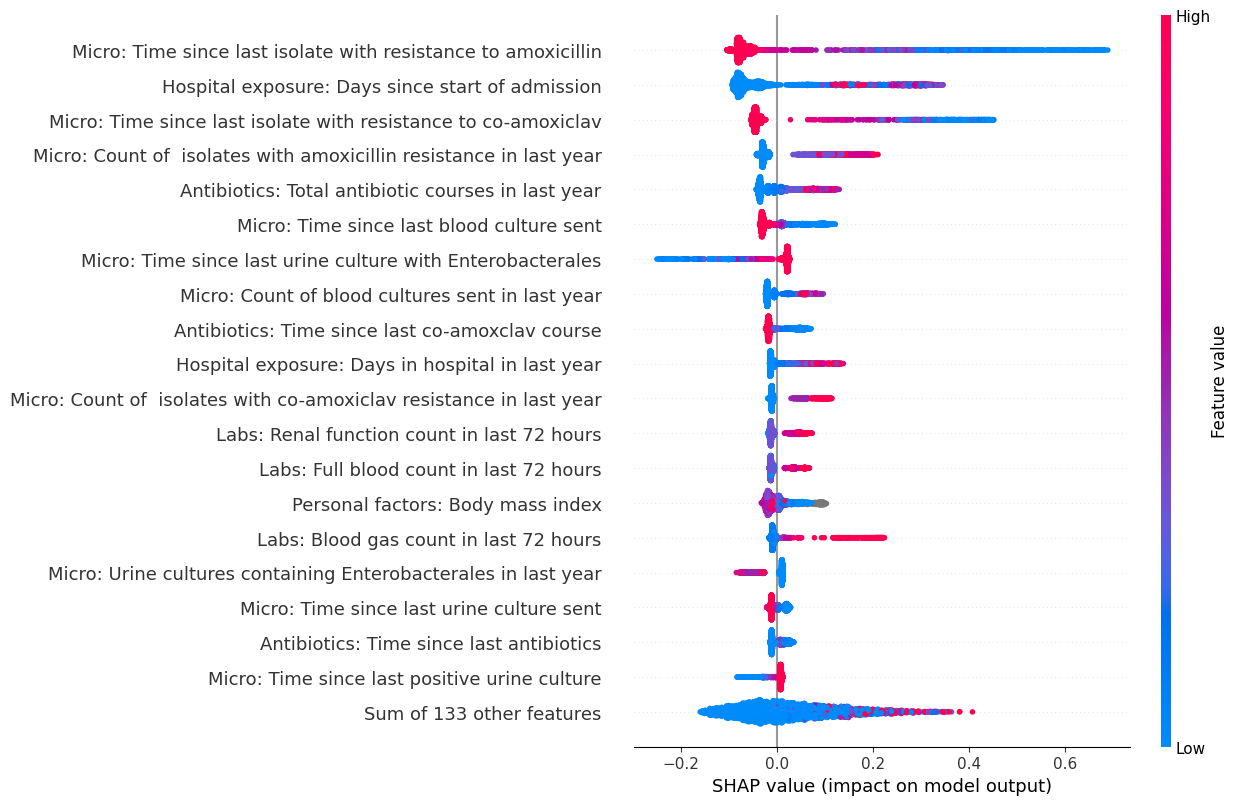

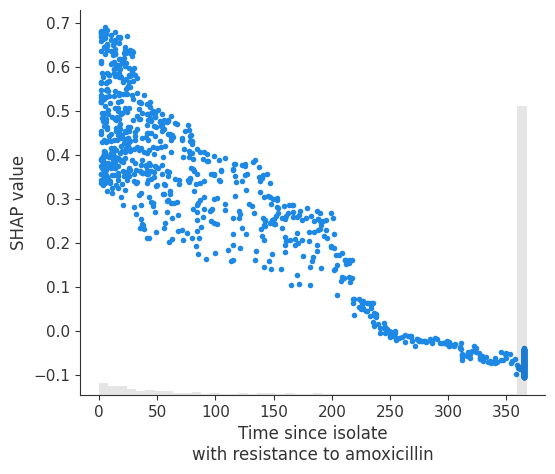

Scale pos weight: 0.4928247734138973
100%|██████████| 100/100 [01:00<00:00,  1.65trial/s, best loss: -0.7064940598980964]
{'colsample_bytree': 0.6, 'gamma': 7, 'learning_rate': 0.005, 'max_depth': 5, 'min_child_weight': 3, 'n_estimators': 390, 'subsample': 0.75}
Baseline model performance (train):
('2X2 confusion matrix:', ['TP', np.int64(1540), 'FP', np.int64(286), 'FN', np.int64(1108), 'TN', np.int64(1019)], 'Accuracy:', np.float64(0.647), 'Balanced accuracy:', np.float64(0.681), 'Sensitivity/Recall:', np.float64(0.582), 'Specificity:', np.float64(0.781), 'PPV/Precision:', np.float64(0.843), 'NPV:', np.float64(0.479), 'F1-score:', np.float64(0.688), 'False positive rate:', np.float64(0.219), 'True positive rate:', np.float64(0.582), 'ROC AUC:', np.float64(0.746))
Baseline model performance (test):
('2X2 confusion matrix:', ['TP', np.int64(244), 'FP', np.int64(65), 'FN', np.int64(215), 'TN', np.int64(187)], 'Accuracy:', np.float64(0.606), 'Balanced accuracy:', np.float64(0.637), 'Sens

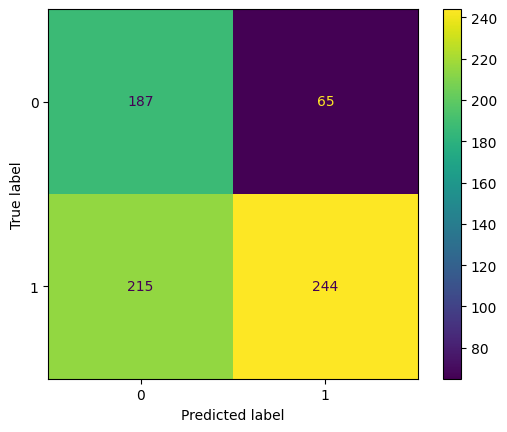

Time taken in seconds: 61
Test set 2
Max F1: 0.8125984251968504 Threshold: 0.4934300788954139
Optimal threshold: 0.6276580200563469
Performance with incremental update
Scale pos weight: 0.4928247734138973
Time taken in seconds: 0
Baseline model performance (train):
('2X2 confusion matrix:', ['TP', np.int64(1483), 'FP', np.int64(270), 'FN', np.int64(1165), 'TN', np.int64(1035)], 'Accuracy:', np.float64(0.637), 'Balanced accuracy:', np.float64(0.677), 'Sensitivity/Recall:', np.float64(0.56), 'Specificity:', np.float64(0.793), 'PPV/Precision:', np.float64(0.846), 'NPV:', np.float64(0.47), 'F1-score:', np.float64(0.674), 'False positive rate:', np.float64(0.207), 'True positive rate:', np.float64(0.56), 'ROC AUC:', np.float64(0.736))
Baseline model performance (test):
('2X2 confusion matrix:', ['TP', np.int64(237), 'FP', np.int64(60), 'FN', np.int64(222), 'TN', np.int64(192)], 'Accuracy:', np.float64(0.603), 'Balanced accuracy:', np.float64(0.639), 'Sensitivity/Recall:', np.float64(0.516),

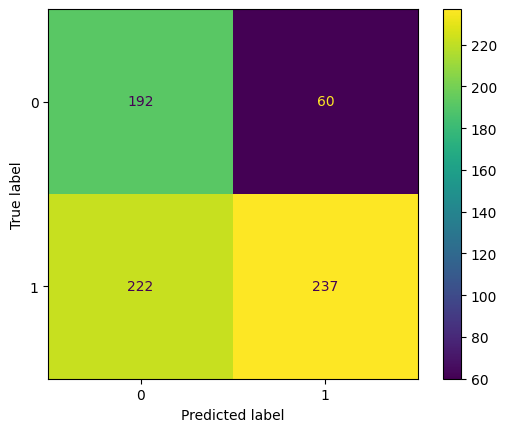

Max F1: 0.8115107913669065 Threshold: 0.48139076282449117
Optimal threshold: 0.6439154697964382
ceftriaxone
Index(['pt', 'index_dt', 'INFO_accessionnumber', 'INFO_bugname',
       'INFO_antibiotic', 'OUTCOME_ast_result', 'INFO_index_dt_since_baseline',
       'INDEX_DATE_index_dt_hour', 'INFO_BASELINE_ABX_baseline_abx',
       'INFO_BASELINE_ABX_last_betalactam',
       ...
       'MICRO_micro_sample_time_last_urine_365d',
       'MICRO_micro_sample_time_last_blood_365d',
       'MICRO_micro_positive_any_species_count_urine_365d',
       'MICRO_micro_positive_time_last_urine_365d',
       'MICRO_micro_positive_any_species_count_blood_365d',
       'MICRO_micro_positive_time_last_blood_365d',
       'MICRO_micro_positive_specific_species_count_urine_365d',
       'MICRO_micro_positive_specific_species_time_last_urine_365d',
       'MICRO_micro_positive_specific_species_count_blood_365d',
       'MICRO_micro_positive_specific_species_time_last_blood_365d'],
      dtype='object', length=1

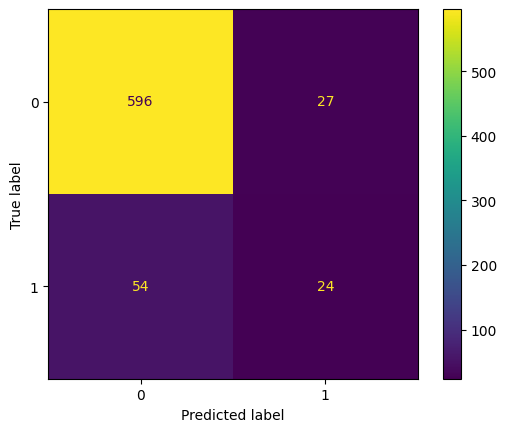

Time taken in seconds: 40
Test set 2
Baseline model performance (train):
('2X2 confusion matrix:', ['TP', np.int64(226), 'FP', np.int64(141), 'FN', np.int64(137), 'TN', np.int64(2760)], 'Accuracy:', np.float64(0.915), 'Balanced accuracy:', np.float64(0.787), 'Sensitivity/Recall:', np.float64(0.623), 'Specificity:', np.float64(0.951), 'PPV/Precision:', np.float64(0.616), 'NPV:', np.float64(0.953), 'F1-score:', np.float64(0.619), 'False positive rate:', np.float64(0.049), 'True positive rate:', np.float64(0.623), 'ROC AUC:', np.float64(0.914))
Baseline model performance (test):
('2X2 confusion matrix:', ['TP', np.int64(29), 'FP', np.int64(33), 'FN', np.int64(56), 'TN', np.int64(594)], 'Accuracy:', np.float64(0.875), 'Balanced accuracy:', np.float64(0.644), 'Sensitivity/Recall:', np.float64(0.341), 'Specificity:', np.float64(0.947), 'PPV/Precision:', np.float64(0.468), 'NPV:', np.float64(0.914), 'F1-score:', np.float64(0.395), 'False positive rate:', np.float64(0.053), 'True positive rate

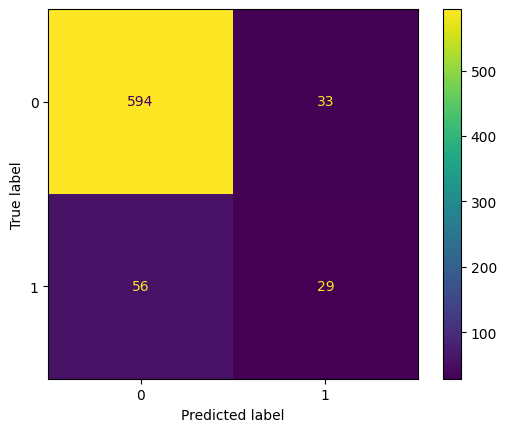

Max F1: 0.6238030095759234 Threshold: 0.17954824904814046
Optimal threshold: 0.09622189777919896


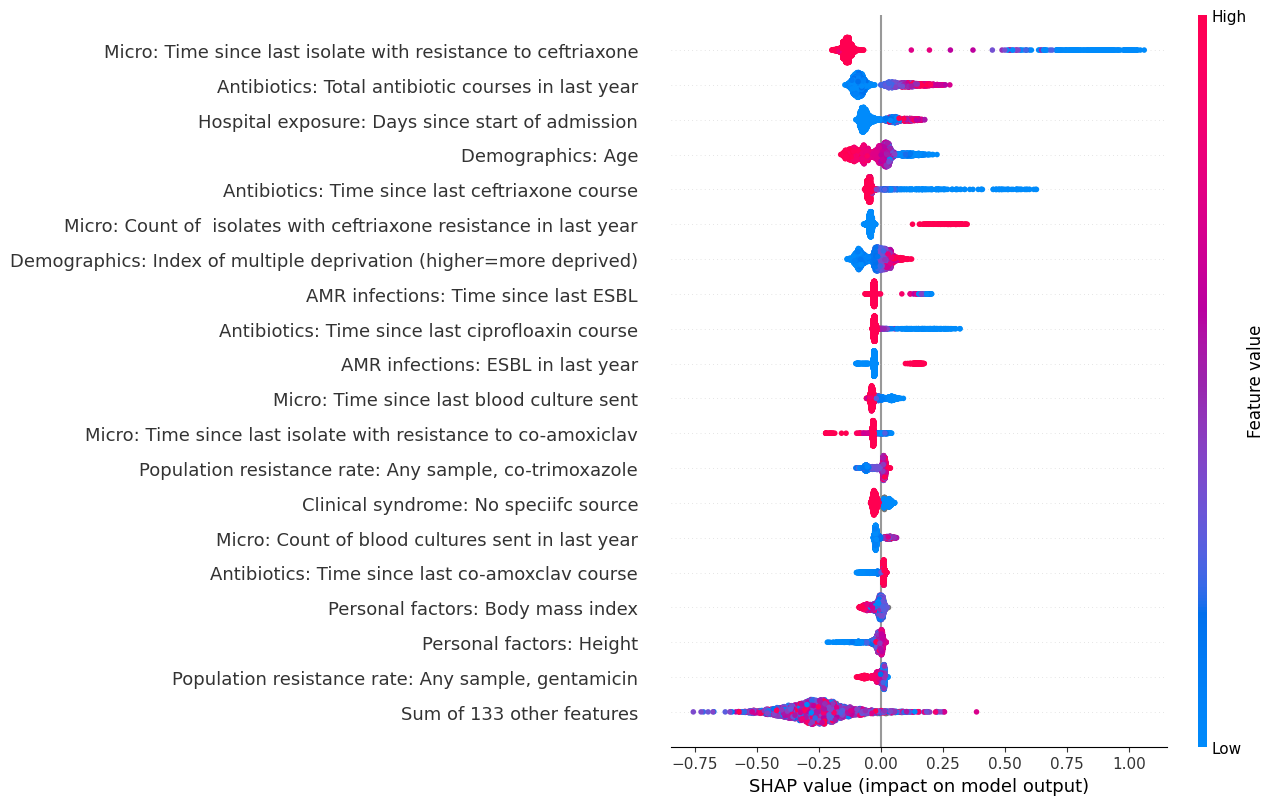

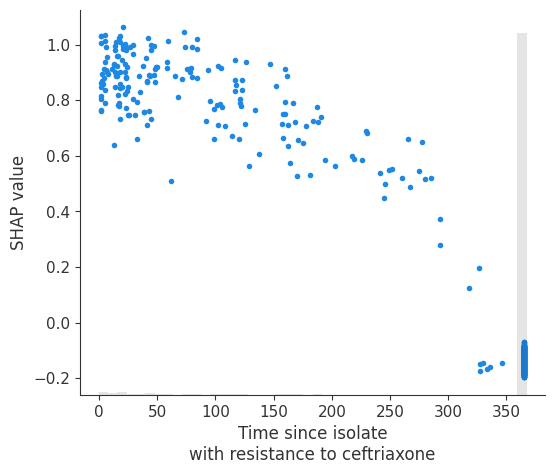

Scale pos weight: 7.99092970521542
100%|██████████| 100/100 [00:35<00:00,  2.79trial/s, best loss: -0.7353041948819639]
{'colsample_bytree': 0.75, 'gamma': 9, 'learning_rate': 0.001, 'max_depth': 5, 'min_child_weight': 5, 'n_estimators': 770, 'subsample': 0.4}
Baseline model performance (train):
('2X2 confusion matrix:', ['TP', np.int64(255), 'FP', np.int64(228), 'FN', np.int64(186), 'TN', np.int64(3296)], 'Accuracy:', np.float64(0.896), 'Balanced accuracy:', np.float64(0.757), 'Sensitivity/Recall:', np.float64(0.578), 'Specificity:', np.float64(0.935), 'PPV/Precision:', np.float64(0.528), 'NPV:', np.float64(0.947), 'F1-score:', np.float64(0.552), 'False positive rate:', np.float64(0.065), 'True positive rate:', np.float64(0.578), 'ROC AUC:', np.float64(0.869))
Baseline model performance (test):
('2X2 confusion matrix:', ['TP', np.int64(32), 'FP', np.int64(55), 'FN', np.int64(53), 'TN', np.int64(572)], 'Accuracy:', np.float64(0.848), 'Balanced accuracy:', np.float64(0.644), 'Sensitivit

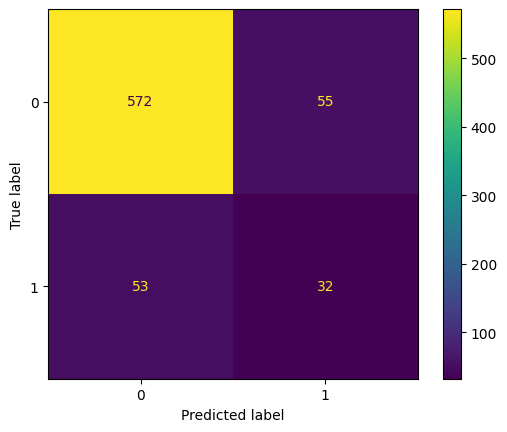

Time taken in seconds: 37
Test set 2
Max F1: 0.5661202185792349 Threshold: 0.16473867404616582
Optimal threshold: 0.11283669748573522
Performance with incremental update
Scale pos weight: 7.99092970521542
Time taken in seconds: 1
Baseline model performance (train):
('2X2 confusion matrix:', ['TP', np.int64(207), 'FP', np.int64(71), 'FN', np.int64(234), 'TN', np.int64(3453)], 'Accuracy:', np.float64(0.923), 'Balanced accuracy:', np.float64(0.725), 'Sensitivity/Recall:', np.float64(0.469), 'Specificity:', np.float64(0.98), 'PPV/Precision:', np.float64(0.745), 'NPV:', np.float64(0.937), 'F1-score:', np.float64(0.576), 'False positive rate:', np.float64(0.02), 'True positive rate:', np.float64(0.469), 'ROC AUC:', np.float64(0.871))
Baseline model performance (test):
('2X2 confusion matrix:', ['TP', np.int64(26), 'FP', np.int64(21), 'FN', np.int64(59), 'TN', np.int64(606)], 'Accuracy:', np.float64(0.888), 'Balanced accuracy:', np.float64(0.636), 'Sensitivity/Recall:', np.float64(0.306), 'Sp

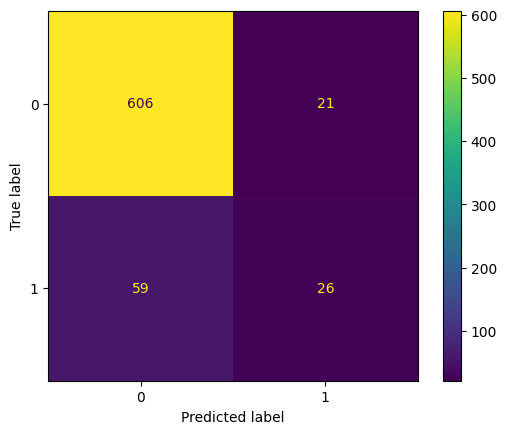

Max F1: 0.6164079822616406 Threshold: 0.18108770578222538
Optimal threshold: 0.10781784350635104
ciprofloxacin
Index(['pt', 'index_dt', 'INFO_accessionnumber', 'INFO_bugname',
       'INFO_antibiotic', 'OUTCOME_ast_result', 'INFO_index_dt_since_baseline',
       'INDEX_DATE_index_dt_hour', 'INFO_BASELINE_ABX_baseline_abx',
       'INFO_BASELINE_ABX_last_betalactam',
       ...
       'MICRO_micro_sample_time_last_urine_365d',
       'MICRO_micro_sample_time_last_blood_365d',
       'MICRO_micro_positive_any_species_count_urine_365d',
       'MICRO_micro_positive_time_last_urine_365d',
       'MICRO_micro_positive_any_species_count_blood_365d',
       'MICRO_micro_positive_time_last_blood_365d',
       'MICRO_micro_positive_specific_species_count_urine_365d',
       'MICRO_micro_positive_specific_species_time_last_urine_365d',
       'MICRO_micro_positive_specific_species_count_blood_365d',
       'MICRO_micro_positive_specific_species_time_last_blood_365d'],
      dtype='object', lengt

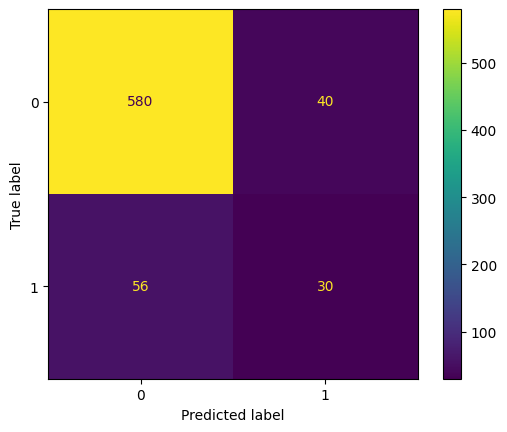

Time taken in seconds: 39
Test set 2
Baseline model performance (train):
('2X2 confusion matrix:', ['TP', np.int64(273), 'FP', np.int64(234), 'FN', np.int64(141), 'TN', np.int64(2627)], 'Accuracy:', np.float64(0.885), 'Balanced accuracy:', np.float64(0.789), 'Sensitivity/Recall:', np.float64(0.659), 'Specificity:', np.float64(0.918), 'PPV/Precision:', np.float64(0.538), 'NPV:', np.float64(0.949), 'F1-score:', np.float64(0.593), 'False positive rate:', np.float64(0.082), 'True positive rate:', np.float64(0.659), 'ROC AUC:', np.float64(0.911))
Baseline model performance (test):
('2X2 confusion matrix:', ['TP', np.int64(29), 'FP', np.int64(61), 'FN', np.int64(55), 'TN', np.int64(575)], 'Accuracy:', np.float64(0.839), 'Balanced accuracy:', np.float64(0.625), 'Sensitivity/Recall:', np.float64(0.345), 'Specificity:', np.float64(0.904), 'PPV/Precision:', np.float64(0.322), 'NPV:', np.float64(0.913), 'F1-score:', np.float64(0.333), 'False positive rate:', np.float64(0.096), 'True positive rate

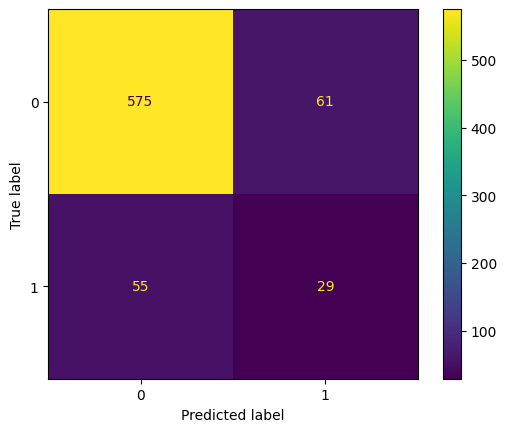

Max F1: 0.5852216748768472 Threshold: 0.17117994345028187
Optimal threshold: 0.12495512381161111


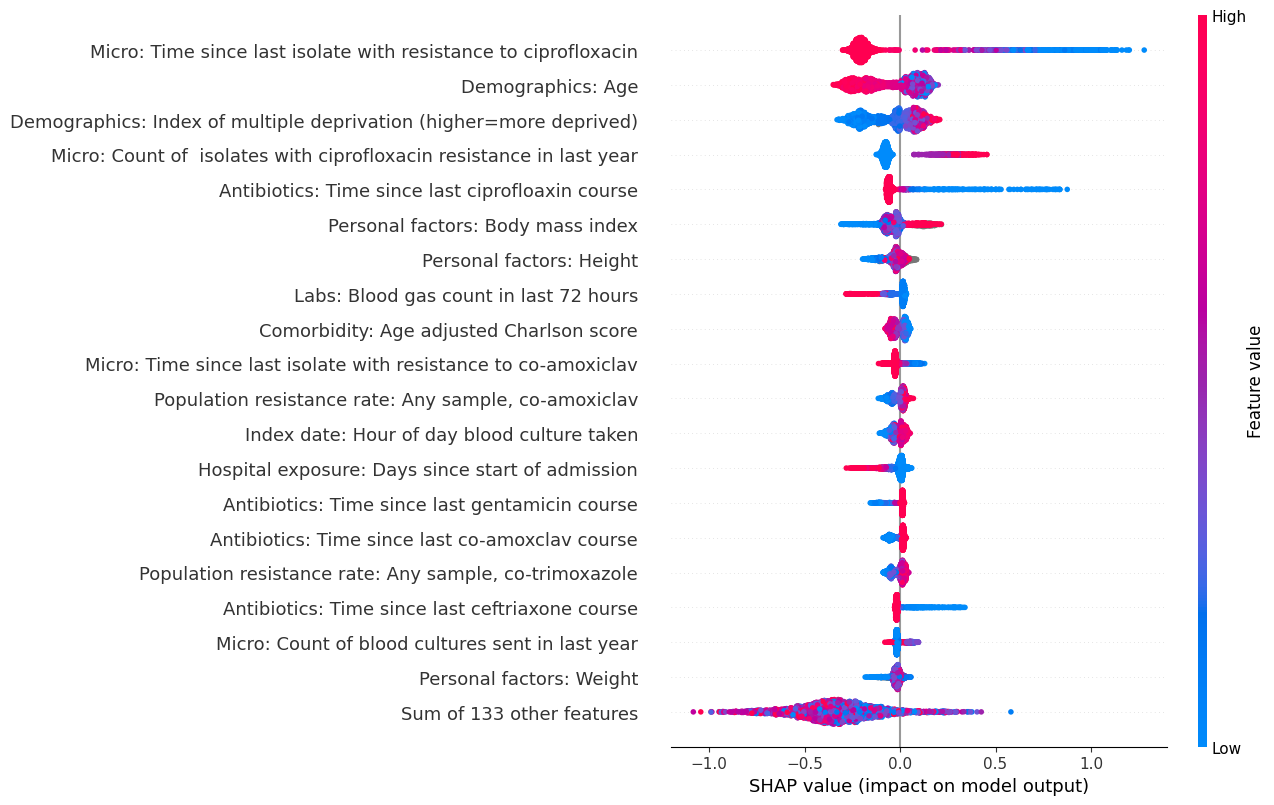

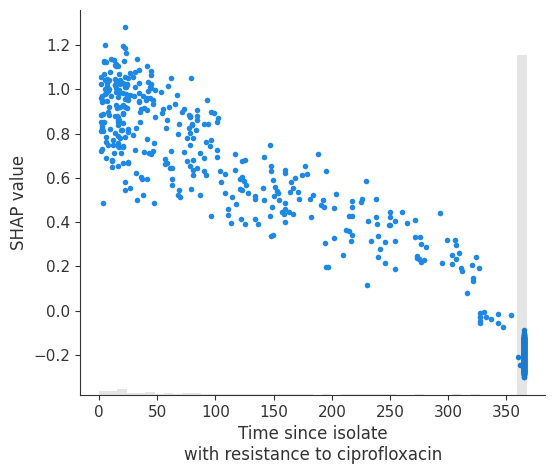

Scale pos weight: 6.962
100%|██████████| 100/100 [00:38<00:00,  2.60trial/s, best loss: -0.7182704393993171]
{'colsample_bytree': 0.55, 'gamma': 7, 'learning_rate': 0.005, 'max_depth': 3, 'min_child_weight': 10, 'n_estimators': 670, 'subsample': 0.6}
Baseline model performance (train):
('2X2 confusion matrix:', ['TP', np.int64(293), 'FP', np.int64(445), 'FN', np.int64(207), 'TN', np.int64(3036)], 'Accuracy:', np.float64(0.836), 'Balanced accuracy:', np.float64(0.729), 'Sensitivity/Recall:', np.float64(0.586), 'Specificity:', np.float64(0.872), 'PPV/Precision:', np.float64(0.397), 'NPV:', np.float64(0.936), 'F1-score:', np.float64(0.473), 'False positive rate:', np.float64(0.128), 'True positive rate:', np.float64(0.586), 'ROC AUC:', np.float64(0.828))
Baseline model performance (test):
('2X2 confusion matrix:', ['TP', np.int64(42), 'FP', np.int64(109), 'FN', np.int64(42), 'TN', np.int64(527)], 'Accuracy:', np.float64(0.79), 'Balanced accuracy:', np.float64(0.664), 'Sensitivity/Recall:'

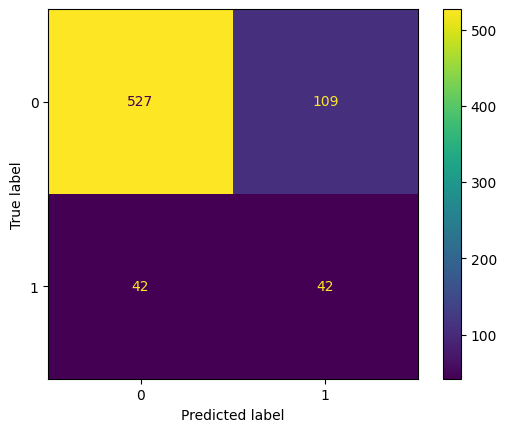

Time taken in seconds: 39
Test set 2
Max F1: 0.4813278008298754 Threshold: 0.15785230519437338
Optimal threshold: 0.1076599654131847
Performance with incremental update
Scale pos weight: 6.962
Time taken in seconds: 0
Baseline model performance (train):
('2X2 confusion matrix:', ['TP', np.int64(317), 'FP', np.int64(365), 'FN', np.int64(183), 'TN', np.int64(3116)], 'Accuracy:', np.float64(0.862), 'Balanced accuracy:', np.float64(0.765), 'Sensitivity/Recall:', np.float64(0.634), 'Specificity:', np.float64(0.895), 'PPV/Precision:', np.float64(0.465), 'NPV:', np.float64(0.945), 'F1-score:', np.float64(0.536), 'False positive rate:', np.float64(0.105), 'True positive rate:', np.float64(0.634), 'ROC AUC:', np.float64(0.878))
Baseline model performance (test):
('2X2 confusion matrix:', ['TP', np.int64(33), 'FP', np.int64(67), 'FN', np.int64(51), 'TN', np.int64(569)], 'Accuracy:', np.float64(0.836), 'Balanced accuracy:', np.float64(0.644), 'Sensitivity/Recall:', np.float64(0.393), 'Specificity

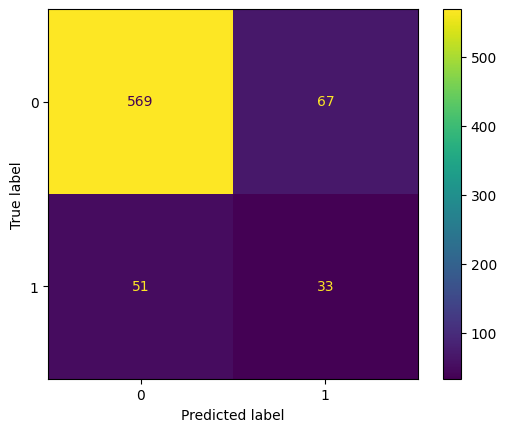

Max F1: 0.5745033112582781 Threshold: 0.16989933171929836
Optimal threshold: 0.11782375406666104
co-amoxiclav
Index(['pt', 'index_dt', 'INFO_accessionnumber', 'INFO_bugname',
       'INFO_antibiotic', 'OUTCOME_ast_result', 'INFO_index_dt_since_baseline',
       'INDEX_DATE_index_dt_hour', 'INFO_BASELINE_ABX_baseline_abx',
       'INFO_BASELINE_ABX_last_betalactam',
       ...
       'MICRO_micro_sample_time_last_urine_365d',
       'MICRO_micro_sample_time_last_blood_365d',
       'MICRO_micro_positive_any_species_count_urine_365d',
       'MICRO_micro_positive_time_last_urine_365d',
       'MICRO_micro_positive_any_species_count_blood_365d',
       'MICRO_micro_positive_time_last_blood_365d',
       'MICRO_micro_positive_specific_species_count_urine_365d',
       'MICRO_micro_positive_specific_species_time_last_urine_365d',
       'MICRO_micro_positive_specific_species_count_blood_365d',
       'MICRO_micro_positive_specific_species_time_last_blood_365d'],
      dtype='object', length

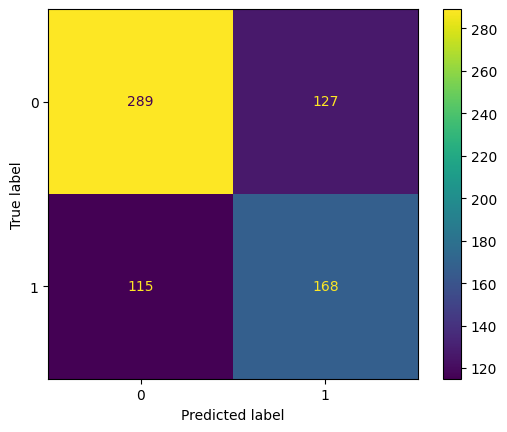

Time taken in seconds: 70
Test set 2
Baseline model performance (train):
('2X2 confusion matrix:', ['TP', np.int64(839), 'FP', np.int64(436), 'FN', np.int64(538), 'TN', np.int64(1444)], 'Accuracy:', np.float64(0.701), 'Balanced accuracy:', np.float64(0.689), 'Sensitivity/Recall:', np.float64(0.609), 'Specificity:', np.float64(0.768), 'PPV/Precision:', np.float64(0.658), 'NPV:', np.float64(0.729), 'F1-score:', np.float64(0.633), 'False positive rate:', np.float64(0.232), 'True positive rate:', np.float64(0.609), 'ROC AUC:', np.float64(0.754))
Baseline model performance (test):
('2X2 confusion matrix:', ['TP', np.int64(122), 'FP', np.int64(132), 'FN', np.int64(123), 'TN', np.int64(333)], 'Accuracy:', np.float64(0.641), 'Balanced accuracy:', np.float64(0.607), 'Sensitivity/Recall:', np.float64(0.498), 'Specificity:', np.float64(0.716), 'PPV/Precision:', np.float64(0.48), 'NPV:', np.float64(0.73), 'F1-score:', np.float64(0.489), 'False positive rate:', np.float64(0.284), 'True positive rat

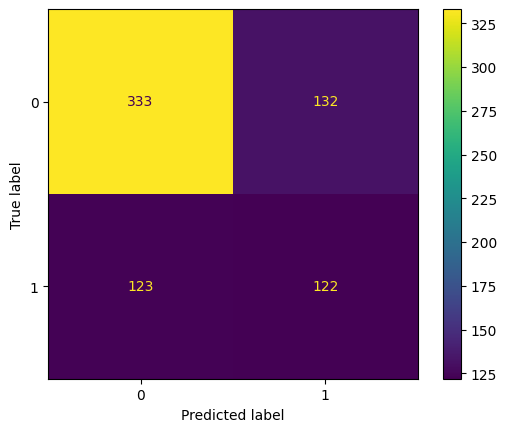

Max F1: 0.6499854524294443 Threshold: 0.31329906075322744
Optimal threshold: 0.4154380311825506


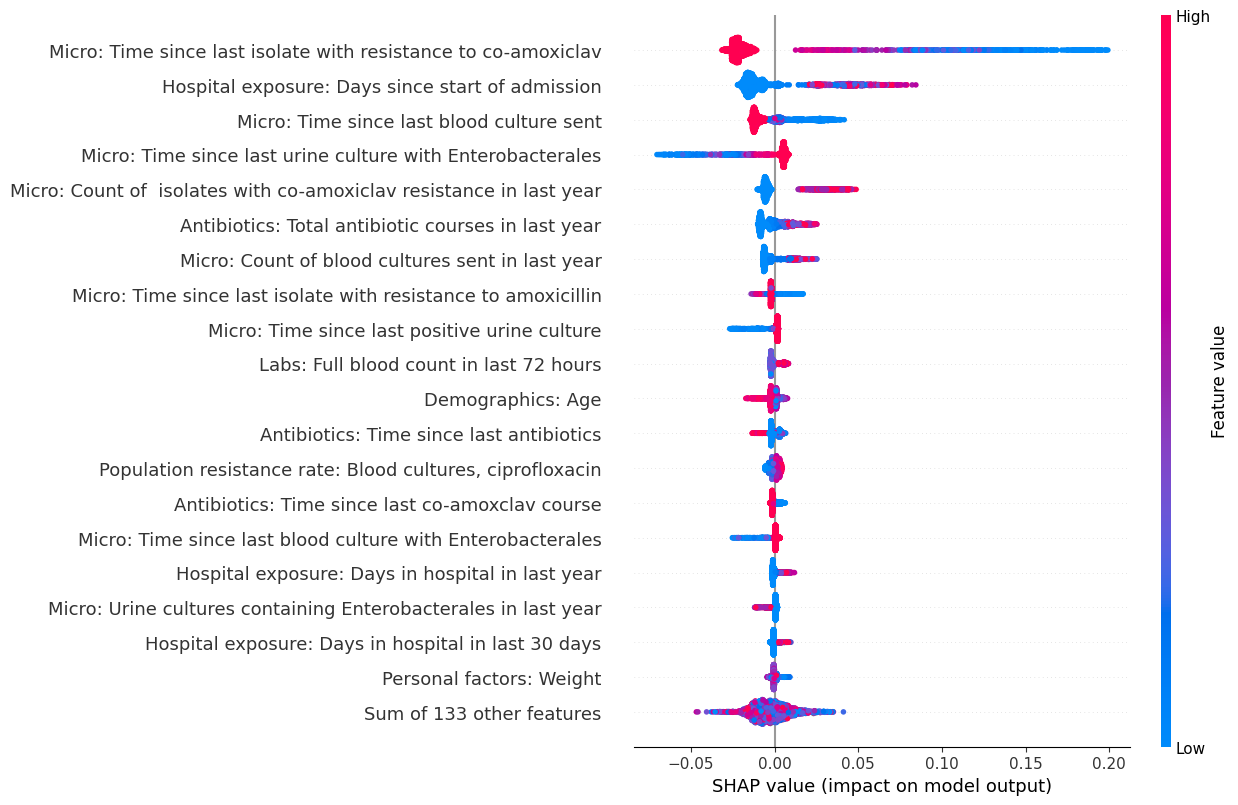

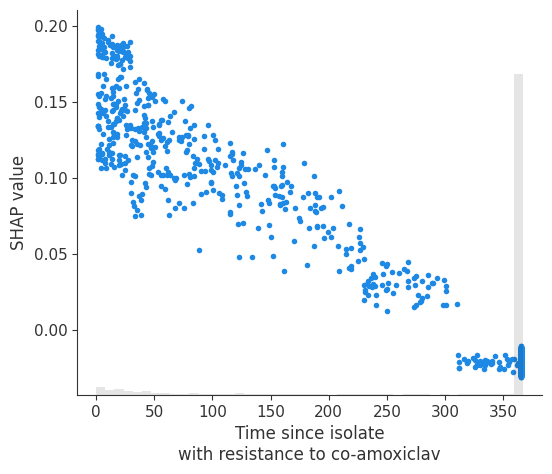

Scale pos weight: 1.383132530120482
100%|██████████| 100/100 [00:59<00:00,  1.67trial/s, best loss: -0.6969102822863229]
{'colsample_bytree': 0.35, 'gamma': 7, 'learning_rate': 0.002, 'max_depth': 5, 'min_child_weight': 2, 'n_estimators': 690, 'subsample': 0.75}
Baseline model performance (train):
('2X2 confusion matrix:', ['TP', np.int64(1009), 'FP', np.int64(529), 'FN', np.int64(651), 'TN', np.int64(1767)], 'Accuracy:', np.float64(0.702), 'Balanced accuracy:', np.float64(0.689), 'Sensitivity/Recall:', np.float64(0.608), 'Specificity:', np.float64(0.77), 'PPV/Precision:', np.float64(0.656), 'NPV:', np.float64(0.731), 'F1-score:', np.float64(0.631), 'False positive rate:', np.float64(0.23), 'True positive rate:', np.float64(0.608), 'ROC AUC:', np.float64(0.756))
Baseline model performance (test):
('2X2 confusion matrix:', ['TP', np.int64(119), 'FP', np.int64(120), 'FN', np.int64(126), 'TN', np.int64(345)], 'Accuracy:', np.float64(0.654), 'Balanced accuracy:', np.float64(0.614), 'Sensit

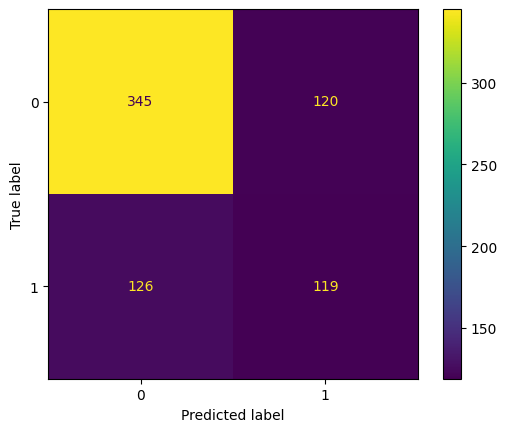

Time taken in seconds: 61
Test set 2
Max F1: 0.6491271207278092 Threshold: 0.31190467999034144
Optimal threshold: 0.4212006467271109
Performance with incremental update
Scale pos weight: 1.383132530120482
Time taken in seconds: 1
Baseline model performance (train):
('2X2 confusion matrix:', ['TP', np.int64(924), 'FP', np.int64(511), 'FN', np.int64(736), 'TN', np.int64(1785)], 'Accuracy:', np.float64(0.685), 'Balanced accuracy:', np.float64(0.667), 'Sensitivity/Recall:', np.float64(0.557), 'Specificity:', np.float64(0.777), 'PPV/Precision:', np.float64(0.644), 'NPV:', np.float64(0.708), 'F1-score:', np.float64(0.597), 'False positive rate:', np.float64(0.223), 'True positive rate:', np.float64(0.557), 'ROC AUC:', np.float64(0.734))
Baseline model performance (test):
('2X2 confusion matrix:', ['TP', np.int64(120), 'FP', np.int64(117), 'FN', np.int64(125), 'TN', np.int64(348)], 'Accuracy:', np.float64(0.659), 'Balanced accuracy:', np.float64(0.619), 'Sensitivity/Recall:', np.float64(0.49)

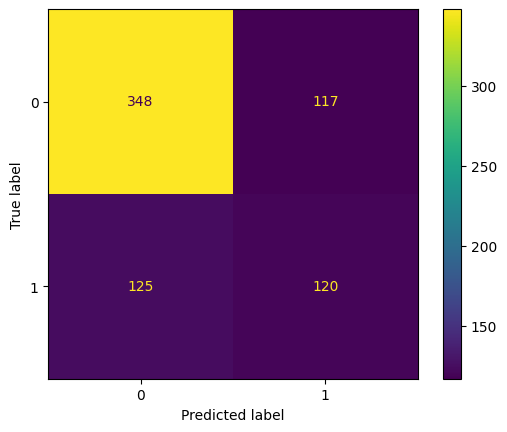

Max F1: 0.6420718299535794 Threshold: 0.3109287368228754
Optimal threshold: 0.42986844440415173
co-trimoxazole
Index(['pt', 'index_dt', 'INFO_accessionnumber', 'INFO_bugname',
       'INFO_antibiotic', 'OUTCOME_ast_result', 'INFO_index_dt_since_baseline',
       'INDEX_DATE_index_dt_hour', 'INFO_BASELINE_ABX_baseline_abx',
       'INFO_BASELINE_ABX_last_betalactam',
       ...
       'MICRO_micro_sample_time_last_urine_365d',
       'MICRO_micro_sample_time_last_blood_365d',
       'MICRO_micro_positive_any_species_count_urine_365d',
       'MICRO_micro_positive_time_last_urine_365d',
       'MICRO_micro_positive_any_species_count_blood_365d',
       'MICRO_micro_positive_time_last_blood_365d',
       'MICRO_micro_positive_specific_species_count_urine_365d',
       'MICRO_micro_positive_specific_species_time_last_urine_365d',
       'MICRO_micro_positive_specific_species_count_blood_365d',
       'MICRO_micro_positive_specific_species_time_last_blood_365d'],
      dtype='object', lengt

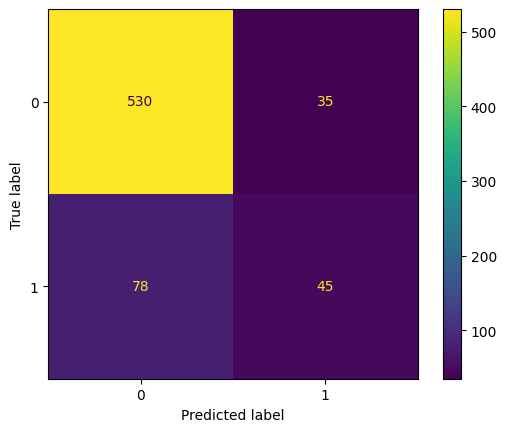

Time taken in seconds: 61
Test set 2
Baseline model performance (train):
('2X2 confusion matrix:', ['TP', np.int64(518), 'FP', np.int64(137), 'FN', np.int64(243), 'TN', np.int64(2304)], 'Accuracy:', np.float64(0.881), 'Balanced accuracy:', np.float64(0.812), 'Sensitivity/Recall:', np.float64(0.681), 'Specificity:', np.float64(0.944), 'PPV/Precision:', np.float64(0.791), 'NPV:', np.float64(0.905), 'F1-score:', np.float64(0.732), 'False positive rate:', np.float64(0.056), 'True positive rate:', np.float64(0.681), 'ROC AUC:', np.float64(0.947))
Baseline model performance (test):
('2X2 confusion matrix:', ['TP', np.int64(43), 'FP', np.int64(41), 'FN', np.int64(84), 'TN', np.int64(535)], 'Accuracy:', np.float64(0.822), 'Balanced accuracy:', np.float64(0.634), 'Sensitivity/Recall:', np.float64(0.339), 'Specificity:', np.float64(0.929), 'PPV/Precision:', np.float64(0.512), 'NPV:', np.float64(0.864), 'F1-score:', np.float64(0.408), 'False positive rate:', np.float64(0.071), 'True positive rate

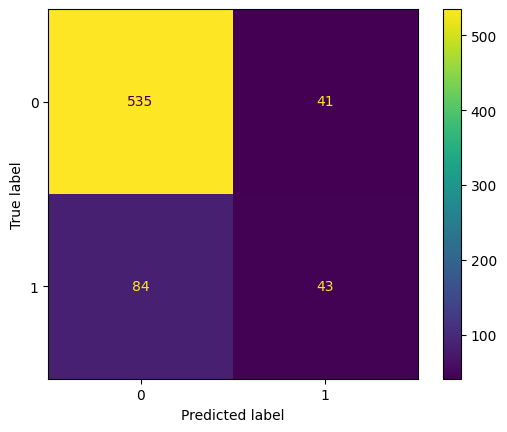

Max F1: 0.78475073313783 Threshold: 0.2369049695257251
Optimal threshold: 0.23238100875610607


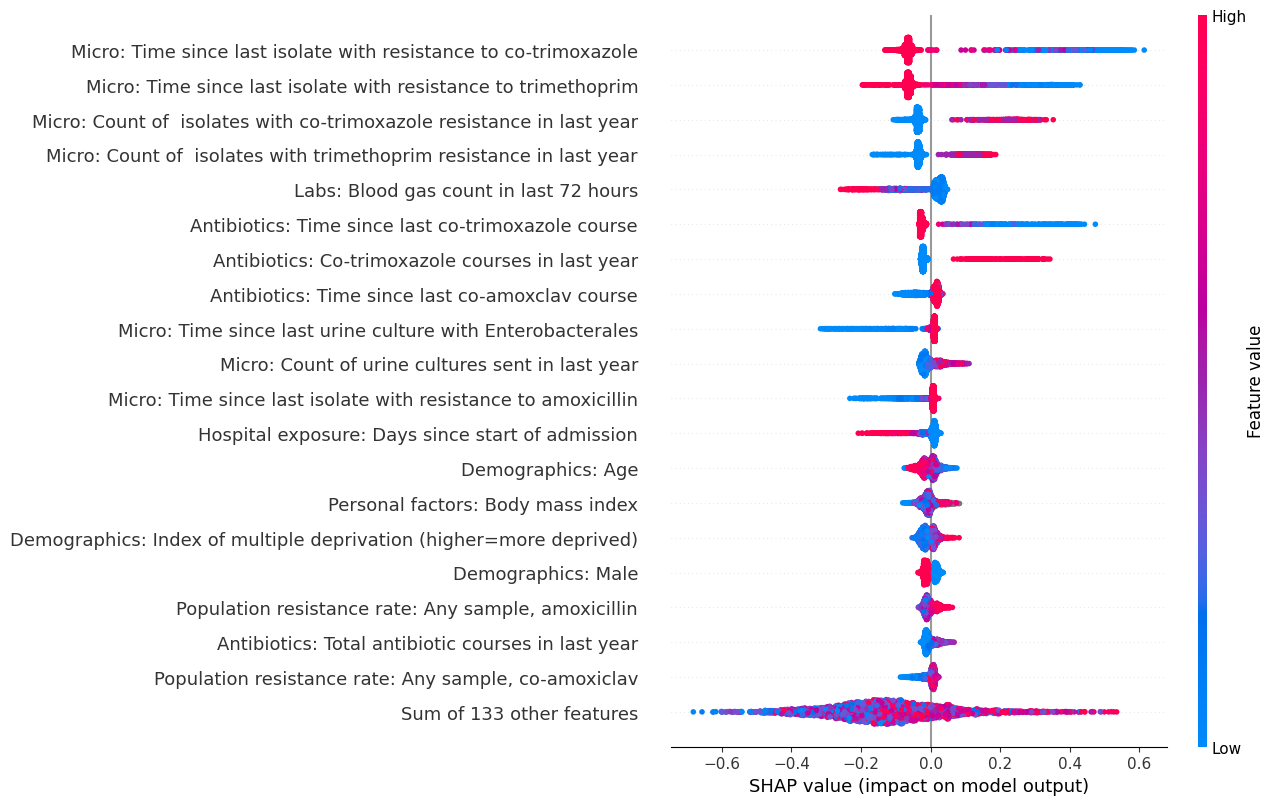

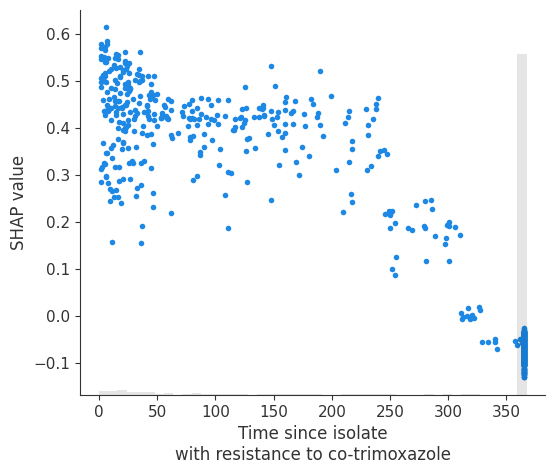

Scale pos weight: 3.4004524886877827
100%|██████████| 100/100 [00:59<00:00,  1.69trial/s, best loss: -0.6982522617265506]
{'colsample_bytree': 0.45, 'gamma': 7, 'learning_rate': 0.002, 'max_depth': 4, 'min_child_weight': 6, 'n_estimators': 1090, 'subsample': 0.7}
Baseline model performance (train):
('2X2 confusion matrix:', ['TP', np.int64(409), 'FP', np.int64(229), 'FN', np.int64(475), 'TN', np.int64(2777)], 'Accuracy:', np.float64(0.819), 'Balanced accuracy:', np.float64(0.693), 'Sensitivity/Recall:', np.float64(0.463), 'Specificity:', np.float64(0.924), 'PPV/Precision:', np.float64(0.641), 'NPV:', np.float64(0.854), 'F1-score:', np.float64(0.537), 'False positive rate:', np.float64(0.076), 'True positive rate:', np.float64(0.463), 'ROC AUC:', np.float64(0.795))
Baseline model performance (test):
('2X2 confusion matrix:', ['TP', np.int64(44), 'FP', np.int64(44), 'FN', np.int64(83), 'TN', np.int64(532)], 'Accuracy:', np.float64(0.819), 'Balanced accuracy:', np.float64(0.635), 'Sensiti

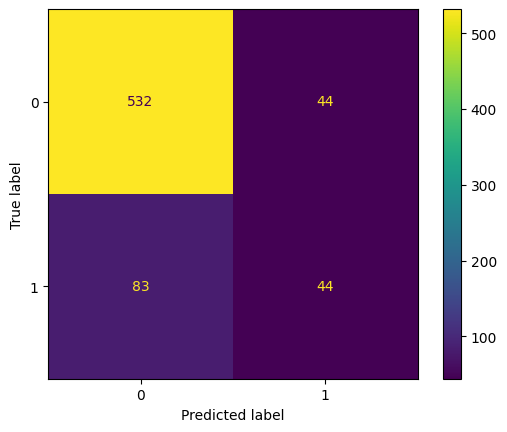

Time taken in seconds: 61
Test set 2
Max F1: 0.563265306122449 Threshold: 0.2074326347592775
Optimal threshold: 0.2066879851681105
Performance with incremental update
Scale pos weight: 3.4004524886877827
Time taken in seconds: 3
Baseline model performance (train):
('2X2 confusion matrix:', ['TP', np.int64(462), 'FP', np.int64(143), 'FN', np.int64(422), 'TN', np.int64(2863)], 'Accuracy:', np.float64(0.855), 'Balanced accuracy:', np.float64(0.738), 'Sensitivity/Recall:', np.float64(0.523), 'Specificity:', np.float64(0.952), 'PPV/Precision:', np.float64(0.764), 'NPV:', np.float64(0.872), 'F1-score:', np.float64(0.621), 'False positive rate:', np.float64(0.048), 'True positive rate:', np.float64(0.523), 'ROC AUC:', np.float64(0.882))
Baseline model performance (test):
('2X2 confusion matrix:', ['TP', np.int64(42), 'FP', np.int64(35), 'FN', np.int64(85), 'TN', np.int64(541)], 'Accuracy:', np.float64(0.829), 'Balanced accuracy:', np.float64(0.635), 'Sensitivity/Recall:', np.float64(0.331), '

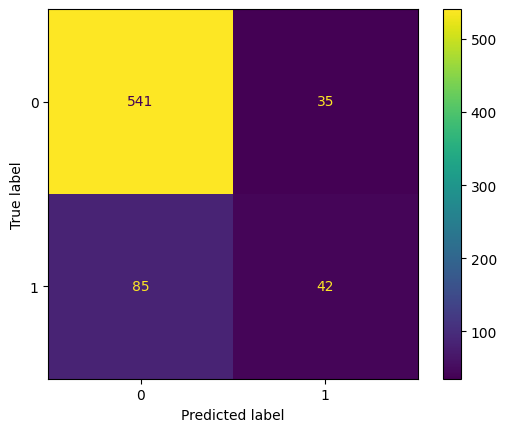

Max F1: 0.7756575554409489 Threshold: 0.23727468000446886
Optimal threshold: 0.21995245222467447
gentamicin
Index(['pt', 'index_dt', 'INFO_accessionnumber', 'INFO_bugname',
       'INFO_antibiotic', 'OUTCOME_ast_result', 'INFO_index_dt_since_baseline',
       'INDEX_DATE_index_dt_hour', 'INFO_BASELINE_ABX_baseline_abx',
       'INFO_BASELINE_ABX_last_betalactam',
       ...
       'MICRO_micro_sample_time_last_urine_365d',
       'MICRO_micro_sample_time_last_blood_365d',
       'MICRO_micro_positive_any_species_count_urine_365d',
       'MICRO_micro_positive_time_last_urine_365d',
       'MICRO_micro_positive_any_species_count_blood_365d',
       'MICRO_micro_positive_time_last_blood_365d',
       'MICRO_micro_positive_specific_species_count_urine_365d',
       'MICRO_micro_positive_specific_species_time_last_urine_365d',
       'MICRO_micro_positive_specific_species_count_blood_365d',
       'MICRO_micro_positive_specific_species_time_last_blood_365d'],
      dtype='object', length=1

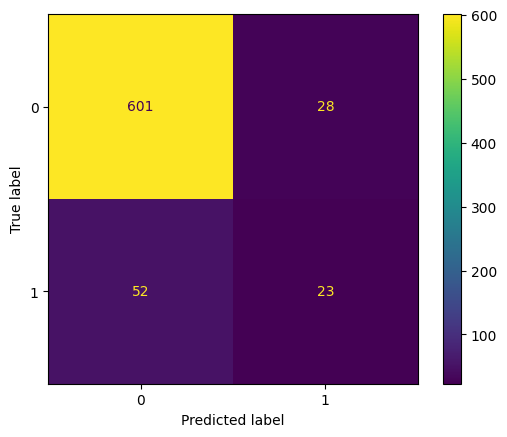

Time taken in seconds: 37
Test set 2
Baseline model performance (train):
('2X2 confusion matrix:', ['TP', np.int64(150), 'FP', np.int64(289), 'FN', np.int64(157), 'TN', np.int64(2670)], 'Accuracy:', np.float64(0.863), 'Balanced accuracy:', np.float64(0.695), 'Sensitivity/Recall:', np.float64(0.489), 'Specificity:', np.float64(0.902), 'PPV/Precision:', np.float64(0.342), 'NPV:', np.float64(0.944), 'F1-score:', np.float64(0.402), 'False positive rate:', np.float64(0.098), 'True positive rate:', np.float64(0.489), 'ROC AUC:', np.float64(0.826))
Baseline model performance (test):
('2X2 confusion matrix:', ['TP', np.int64(22), 'FP', np.int64(23), 'FN', np.int64(57), 'TN', np.int64(613)], 'Accuracy:', np.float64(0.888), 'Balanced accuracy:', np.float64(0.621), 'Sensitivity/Recall:', np.float64(0.278), 'Specificity:', np.float64(0.964), 'PPV/Precision:', np.float64(0.489), 'NPV:', np.float64(0.915), 'F1-score:', np.float64(0.355), 'False positive rate:', np.float64(0.036), 'True positive rate

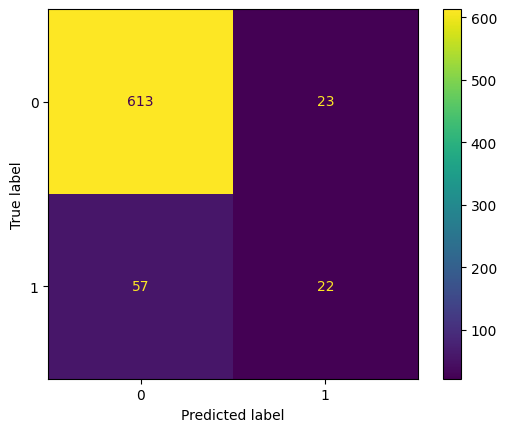

Max F1: 0.43130434782608695 Threshold: 0.1523473345235253
Optimal threshold: 0.0802610514607475


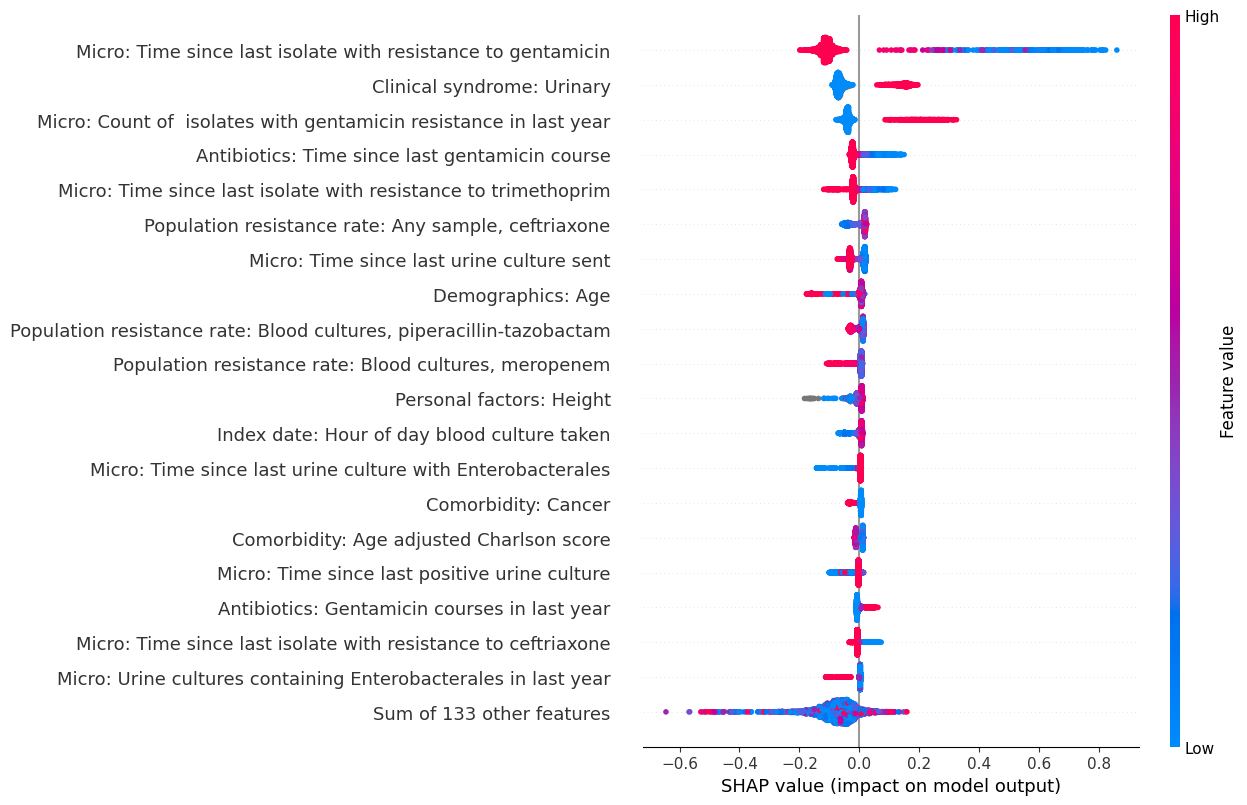

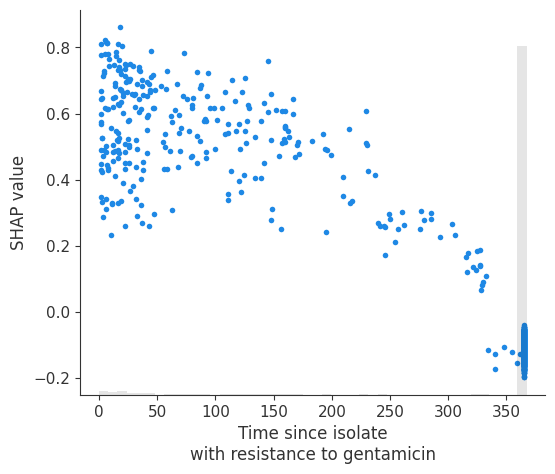

Scale pos weight: 9.392670157068062
100%|██████████| 100/100 [00:34<00:00,  2.88trial/s, best loss: -0.6831293135666543]
{'colsample_bytree': 0.7, 'gamma': 4, 'learning_rate': 0.005, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 250, 'subsample': 0.35}
Baseline model performance (train):
('2X2 confusion matrix:', ['TP', np.int64(180), 'FP', np.int64(265), 'FN', np.int64(202), 'TN', np.int64(3323)], 'Accuracy:', np.float64(0.882), 'Balanced accuracy:', np.float64(0.699), 'Sensitivity/Recall:', np.float64(0.471), 'Specificity:', np.float64(0.926), 'PPV/Precision:', np.float64(0.404), 'NPV:', np.float64(0.943), 'F1-score:', np.float64(0.435), 'False positive rate:', np.float64(0.074), 'True positive rate:', np.float64(0.471), 'ROC AUC:', np.float64(0.817))
Baseline model performance (test):
('2X2 confusion matrix:', ['TP', np.int64(28), 'FP', np.int64(65), 'FN', np.int64(51), 'TN', np.int64(571)], 'Accuracy:', np.float64(0.838), 'Balanced accuracy:', np.float64(0.626), 'Sensitivi

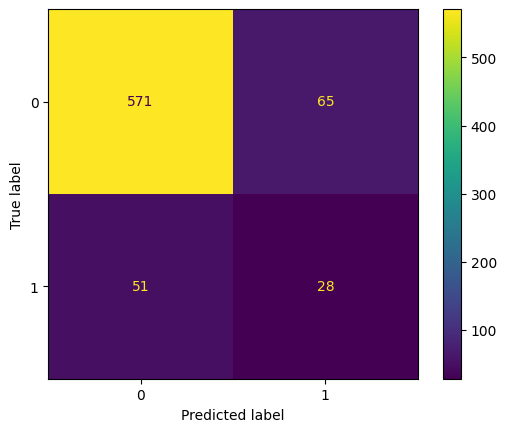

Time taken in seconds: 35
Test set 2
Max F1: 0.44385733157199475 Threshold: 0.14656187335036822
Optimal threshold: 0.08643499285699094
Performance with incremental update
Scale pos weight: 9.392670157068062
Time taken in seconds: 0
Baseline model performance (train):
('2X2 confusion matrix:', ['TP', np.int64(193), 'FP', np.int64(356), 'FN', np.int64(189), 'TN', np.int64(3232)], 'Accuracy:', np.float64(0.863), 'Balanced accuracy:', np.float64(0.703), 'Sensitivity/Recall:', np.float64(0.505), 'Specificity:', np.float64(0.901), 'PPV/Precision:', np.float64(0.352), 'NPV:', np.float64(0.945), 'F1-score:', np.float64(0.415), 'False positive rate:', np.float64(0.099), 'True positive rate:', np.float64(0.505), 'ROC AUC:', np.float64(0.803))
Baseline model performance (test):
('2X2 confusion matrix:', ['TP', np.int64(27), 'FP', np.int64(53), 'FN', np.int64(52), 'TN', np.int64(583)], 'Accuracy:', np.float64(0.853), 'Balanced accuracy:', np.float64(0.629), 'Sensitivity/Recall:', np.float64(0.342)

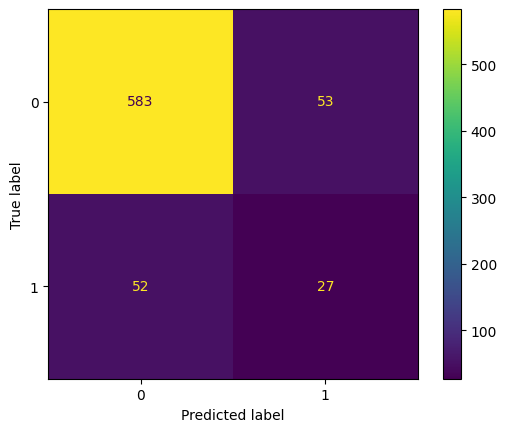

Max F1: 0.4393939393939394 Threshold: 0.13993769098641198
Optimal threshold: 0.07814390054774942
piperacillin-tazobactam
Index(['pt', 'index_dt', 'INFO_accessionnumber', 'INFO_bugname',
       'INFO_antibiotic', 'OUTCOME_ast_result', 'INFO_index_dt_since_baseline',
       'INDEX_DATE_index_dt_hour', 'INFO_BASELINE_ABX_baseline_abx',
       'INFO_BASELINE_ABX_last_betalactam',
       ...
       'MICRO_micro_sample_time_last_urine_365d',
       'MICRO_micro_sample_time_last_blood_365d',
       'MICRO_micro_positive_any_species_count_urine_365d',
       'MICRO_micro_positive_time_last_urine_365d',
       'MICRO_micro_positive_any_species_count_blood_365d',
       'MICRO_micro_positive_time_last_blood_365d',
       'MICRO_micro_positive_specific_species_count_urine_365d',
       'MICRO_micro_positive_specific_species_time_last_urine_365d',
       'MICRO_micro_positive_specific_species_count_blood_365d',
       'MICRO_micro_positive_specific_species_time_last_blood_365d'],
      dtype='obje

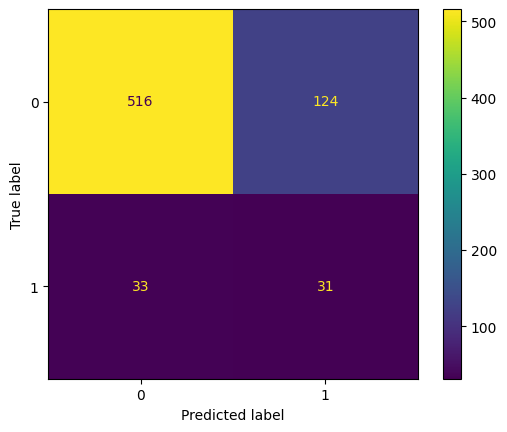

Time taken in seconds: 37
Test set 2
Baseline model performance (train):
('2X2 confusion matrix:', ['TP', np.int64(184), 'FP', np.int64(368), 'FN', np.int64(30), 'TN', np.int64(2691)], 'Accuracy:', np.float64(0.878), 'Balanced accuracy:', np.float64(0.87), 'Sensitivity/Recall:', np.float64(0.86), 'Specificity:', np.float64(0.88), 'PPV/Precision:', np.float64(0.333), 'NPV:', np.float64(0.989), 'F1-score:', np.float64(0.48), 'False positive rate:', np.float64(0.12), 'True positive rate:', np.float64(0.86), 'ROC AUC:', np.float64(0.941))
Baseline model performance (test):
('2X2 confusion matrix:', ['TP', np.int64(28), 'FP', np.int64(134), 'FN', np.int64(35), 'TN', np.int64(517)], 'Accuracy:', np.float64(0.763), 'Balanced accuracy:', np.float64(0.619), 'Sensitivity/Recall:', np.float64(0.444), 'Specificity:', np.float64(0.794), 'PPV/Precision:', np.float64(0.173), 'NPV:', np.float64(0.937), 'F1-score:', np.float64(0.249), 'False positive rate:', np.float64(0.206), 'True positive rate:', np

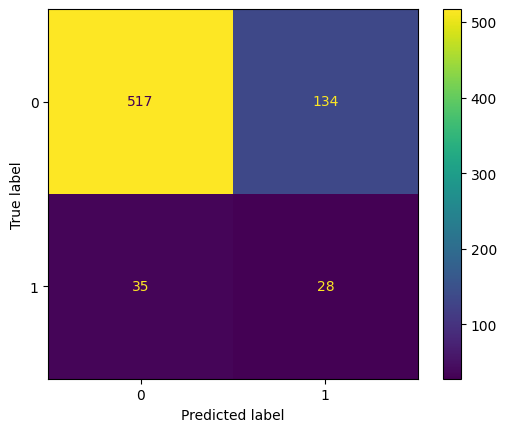

Max F1: 0.5925925925925926 Threshold: 0.17790526667962958
Optimal threshold: 0.10435568219681823


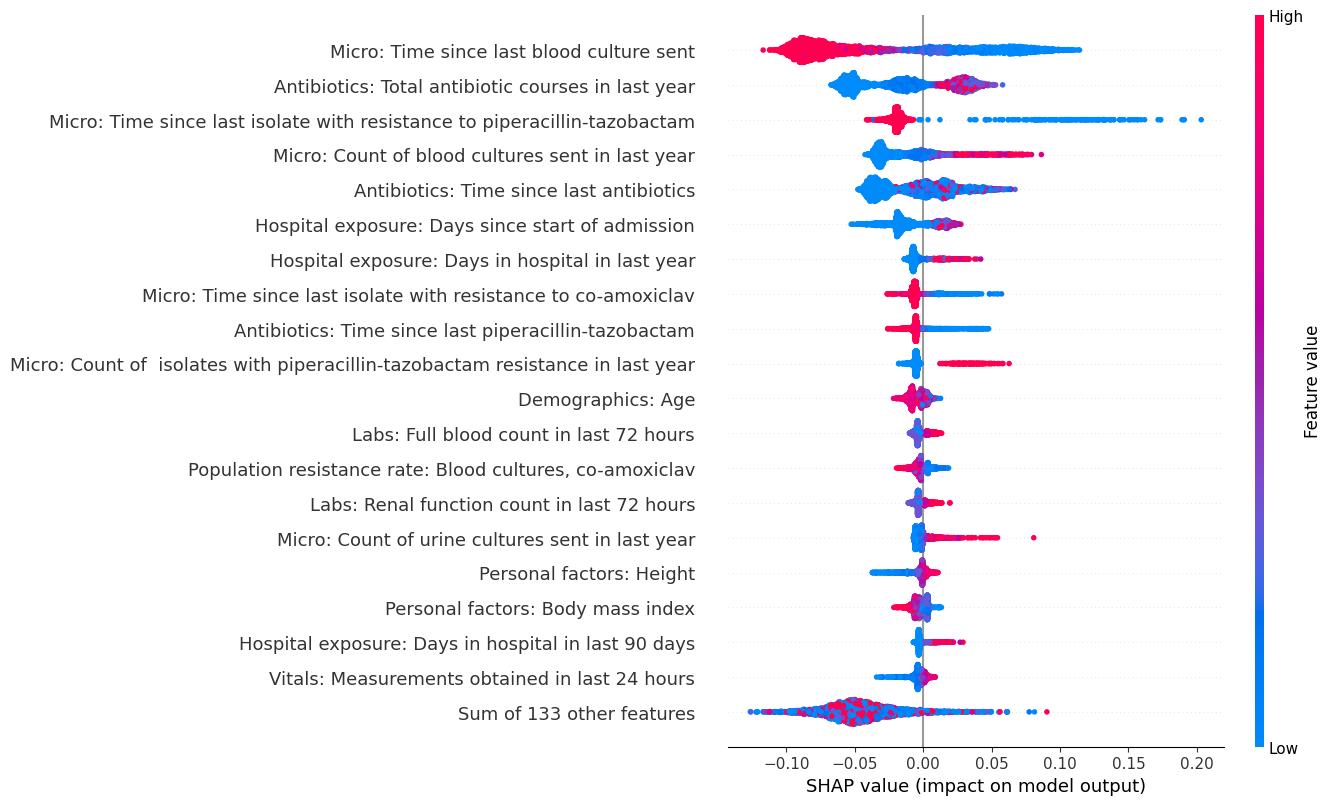

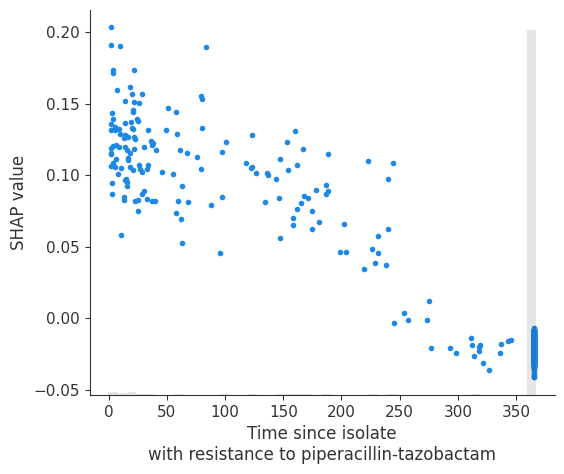

Scale pos weight: 13.305755395683454
100%|██████████| 100/100 [00:37<00:00,  2.64trial/s, best loss: -0.8027679939888515]
{'colsample_bytree': 0.5, 'gamma': 3, 'learning_rate': 0.0002, 'max_depth': 4, 'min_child_weight': 3, 'n_estimators': 750, 'subsample': 0.65}
Baseline model performance (train):
('2X2 confusion matrix:', ['TP', np.int64(200), 'FP', np.int64(591), 'FN', np.int64(78), 'TN', np.int64(3108)], 'Accuracy:', np.float64(0.832), 'Balanced accuracy:', np.float64(0.78), 'Sensitivity/Recall:', np.float64(0.719), 'Specificity:', np.float64(0.84), 'PPV/Precision:', np.float64(0.253), 'NPV:', np.float64(0.976), 'F1-score:', np.float64(0.374), 'False positive rate:', np.float64(0.16), 'True positive rate:', np.float64(0.719), 'ROC AUC:', np.float64(0.876))
Baseline model performance (test):
('2X2 confusion matrix:', ['TP', np.int64(31), 'FP', np.int64(146), 'FN', np.int64(32), 'TN', np.int64(505)], 'Accuracy:', np.float64(0.751), 'Balanced accuracy:', np.float64(0.634), 'Sensitivit

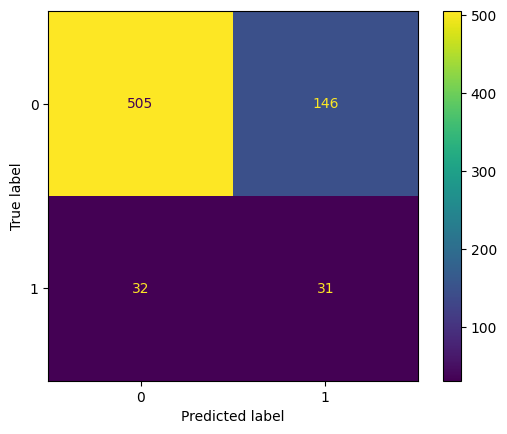

Time taken in seconds: 39
Test set 2
Max F1: 0.49794238683127573 Threshold: 0.25671134083008296
Optimal threshold: 0.07769506033346373
Performance with incremental update
Scale pos weight: 13.305755395683454
Time taken in seconds: 0
Baseline model performance (train):
('2X2 confusion matrix:', ['TP', np.int64(188), 'FP', np.int64(302), 'FN', np.int64(90), 'TN', np.int64(3397)], 'Accuracy:', np.float64(0.901), 'Balanced accuracy:', np.float64(0.797), 'Sensitivity/Recall:', np.float64(0.676), 'Specificity:', np.float64(0.918), 'PPV/Precision:', np.float64(0.384), 'NPV:', np.float64(0.974), 'F1-score:', np.float64(0.49), 'False positive rate:', np.float64(0.082), 'True positive rate:', np.float64(0.676), 'ROC AUC:', np.float64(0.909))
Baseline model performance (test):
('2X2 confusion matrix:', ['TP', np.int64(21), 'FP', np.int64(86), 'FN', np.int64(42), 'TN', np.int64(565)], 'Accuracy:', np.float64(0.821), 'Balanced accuracy:', np.float64(0.601), 'Sensitivity/Recall:', np.float64(0.333),

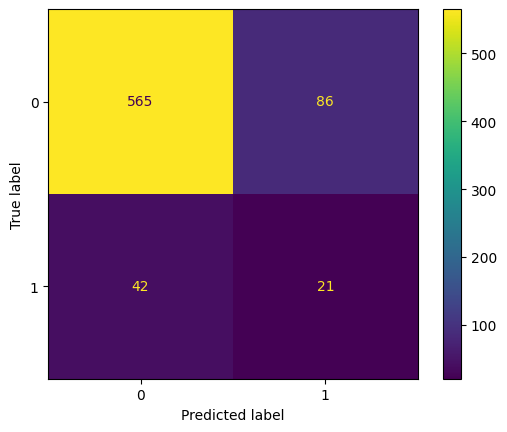

Max F1: 0.5591054313099041 Threshold: 0.18520599815576236
Optimal threshold: 0.08811499828759915
amoxicillin
Index(['pt', 'index_dt', 'INFO_accessionnumber', 'INFO_bugname',
       'INFO_antibiotic', 'OUTCOME_ast_result', 'INFO_index_dt_since_baseline',
       'INDEX_DATE_index_dt_hour', 'INFO_BASELINE_ABX_baseline_abx',
       'INFO_BASELINE_ABX_last_betalactam',
       ...
       'MICRO_micro_sample_time_last_urine_365d',
       'MICRO_micro_sample_time_last_blood_365d',
       'MICRO_micro_positive_any_species_count_urine_365d',
       'MICRO_micro_positive_time_last_urine_365d',
       'MICRO_micro_positive_any_species_count_blood_365d',
       'MICRO_micro_positive_time_last_blood_365d',
       'MICRO_micro_positive_specific_species_count_urine_365d',
       'MICRO_micro_positive_specific_species_time_last_urine_365d',
       'MICRO_micro_positive_specific_species_count_blood_365d',
       'MICRO_micro_positive_specific_species_time_last_blood_365d'],
      dtype='object', length=

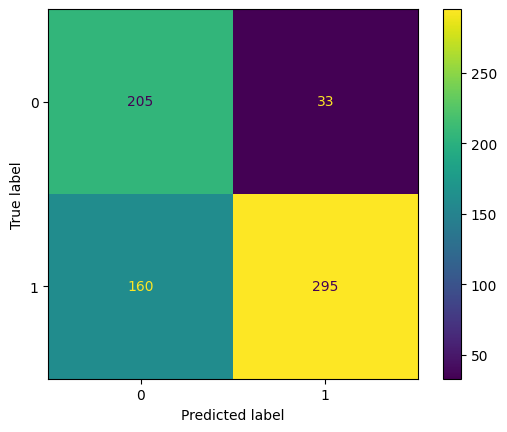

Time taken in seconds: 76
Test set 2
Baseline model performance (train):
('2X2 confusion matrix:', ['TP', np.int64(1358), 'FP', np.int64(100), 'FN', np.int64(835), 'TN', np.int64(967)], 'Accuracy:', np.float64(0.713), 'Balanced accuracy:', np.float64(0.763), 'Sensitivity/Recall:', np.float64(0.619), 'Specificity:', np.float64(0.906), 'PPV/Precision:', np.float64(0.931), 'NPV:', np.float64(0.537), 'F1-score:', np.float64(0.744), 'False positive rate:', np.float64(0.094), 'True positive rate:', np.float64(0.619), 'ROC AUC:', np.float64(0.826))
Baseline model performance (test):
('2X2 confusion matrix:', ['TP', np.int64(288), 'FP', np.int64(24), 'FN', np.int64(171), 'TN', np.int64(228)], 'Accuracy:', np.float64(0.726), 'Balanced accuracy:', np.float64(0.766), 'Sensitivity/Recall:', np.float64(0.627), 'Specificity:', np.float64(0.905), 'PPV/Precision:', np.float64(0.923), 'NPV:', np.float64(0.571), 'F1-score:', np.float64(0.747), 'False positive rate:', np.float64(0.095), 'True positive ra

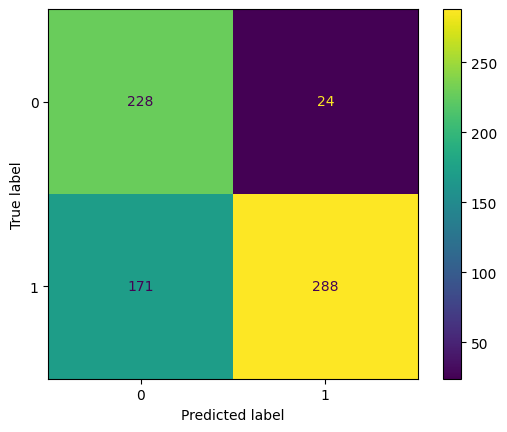

Max F1: 0.824138617805218 Threshold: 0.41524184984271895
Optimal threshold: 0.691100215716055


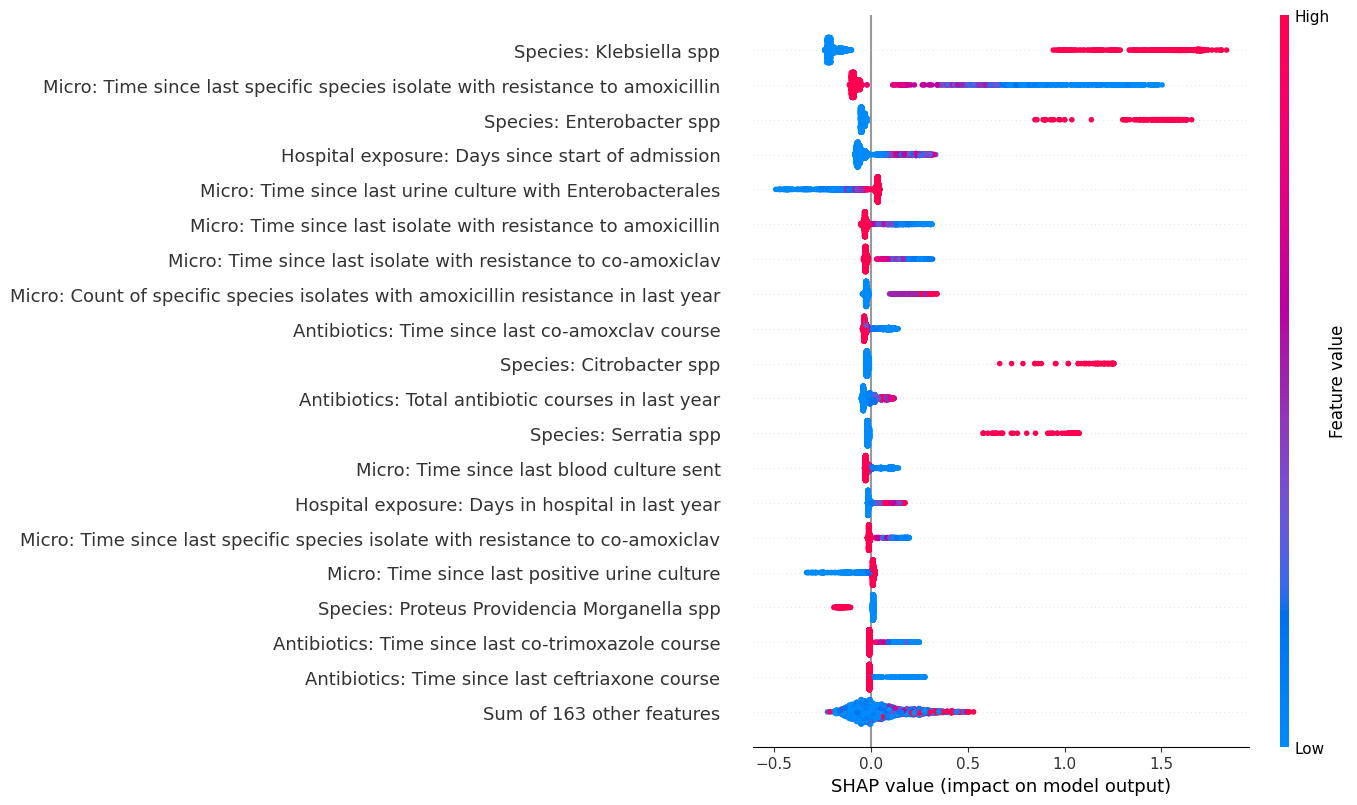

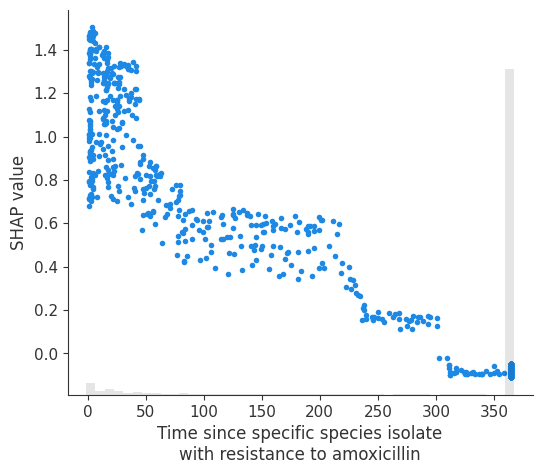

Scale pos weight: 0.4928247734138973
100%|██████████| 100/100 [01:13<00:00,  1.36trial/s, best loss: -0.7925655903353315]
{'colsample_bytree': 0.75, 'gamma': 11, 'learning_rate': 0.002, 'max_depth': 5, 'min_child_weight': 4, 'n_estimators': 1230, 'subsample': 0.75}
Baseline model performance (train):
('2X2 confusion matrix:', ['TP', np.int64(1482), 'FP', np.int64(81), 'FN', np.int64(1166), 'TN', np.int64(1224)], 'Accuracy:', np.float64(0.685), 'Balanced accuracy:', np.float64(0.749), 'Sensitivity/Recall:', np.float64(0.56), 'Specificity:', np.float64(0.938), 'PPV/Precision:', np.float64(0.948), 'NPV:', np.float64(0.512), 'F1-score:', np.float64(0.704), 'False positive rate:', np.float64(0.062), 'True positive rate:', np.float64(0.56), 'ROC AUC:', np.float64(0.815))
Baseline model performance (test):
('2X2 confusion matrix:', ['TP', np.int64(273), 'FP', np.int64(18), 'FN', np.int64(186), 'TN', np.int64(234)], 'Accuracy:', np.float64(0.713), 'Balanced accuracy:', np.float64(0.762), 'Sens

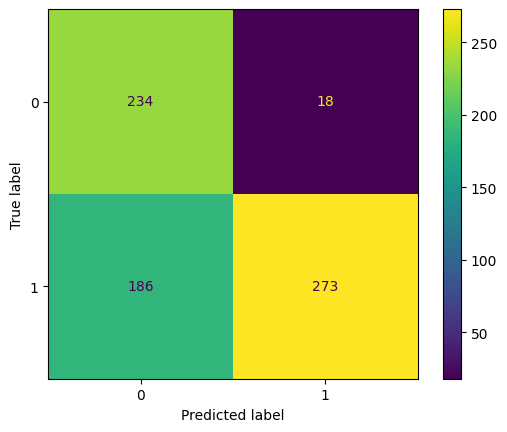

Time taken in seconds: 75
Test set 2
Max F1: 0.8255487704241623 Threshold: 0.4024604962596127
Optimal threshold: 0.7100272571507833
Performance with incremental update
Scale pos weight: 0.4928247734138973
Time taken in seconds: 1
Baseline model performance (train):
('2X2 confusion matrix:', ['TP', np.int64(1612), 'FP', np.int64(115), 'FN', np.int64(1036), 'TN', np.int64(1190)], 'Accuracy:', np.float64(0.709), 'Balanced accuracy:', np.float64(0.76), 'Sensitivity/Recall:', np.float64(0.609), 'Specificity:', np.float64(0.912), 'PPV/Precision:', np.float64(0.933), 'NPV:', np.float64(0.535), 'F1-score:', np.float64(0.737), 'False positive rate:', np.float64(0.088), 'True positive rate:', np.float64(0.609), 'ROC AUC:', np.float64(0.826))
Baseline model performance (test):
('2X2 confusion matrix:', ['TP', np.int64(287), 'FP', np.int64(23), 'FN', np.int64(172), 'TN', np.int64(229)], 'Accuracy:', np.float64(0.726), 'Balanced accuracy:', np.float64(0.767), 'Sensitivity/Recall:', np.float64(0.625

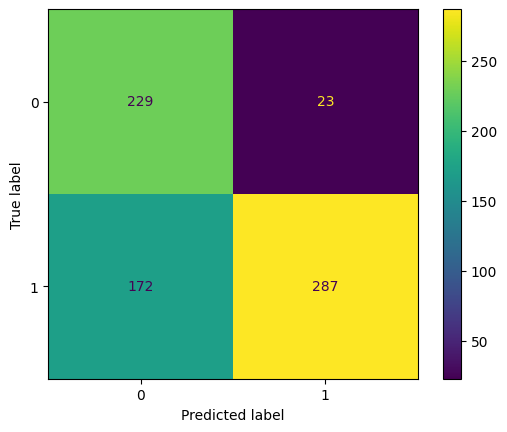

Max F1: 0.8256638627742042 Threshold: 0.4018693389139876
Optimal threshold: 0.709787261917845
ceftriaxone
Index(['pt', 'index_dt', 'INFO_accessionnumber', 'INFO_bugname',
       'INFO_antibiotic', 'OUTCOME_ast_result', 'INFO_index_dt_since_baseline',
       'INDEX_DATE_index_dt_hour', 'INFO_BASELINE_ABX_baseline_abx',
       'INFO_BASELINE_ABX_last_betalactam',
       ...
       'MICRO_micro_sample_time_last_urine_365d',
       'MICRO_micro_sample_time_last_blood_365d',
       'MICRO_micro_positive_any_species_count_urine_365d',
       'MICRO_micro_positive_time_last_urine_365d',
       'MICRO_micro_positive_any_species_count_blood_365d',
       'MICRO_micro_positive_time_last_blood_365d',
       'MICRO_micro_positive_specific_species_count_urine_365d',
       'MICRO_micro_positive_specific_species_time_last_urine_365d',
       'MICRO_micro_positive_specific_species_count_blood_365d',
       'MICRO_micro_positive_specific_species_time_last_blood_365d'],
      dtype='object', length=180

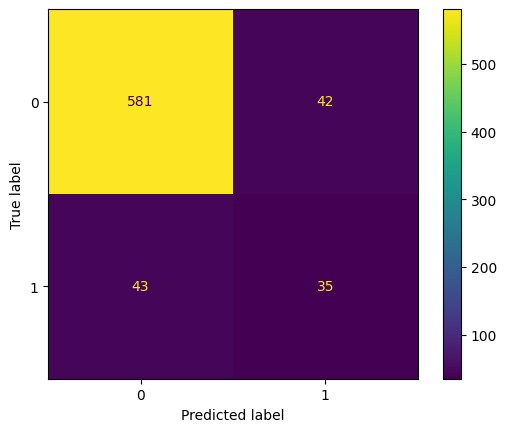

Time taken in seconds: 41
Test set 2
Baseline model performance (train):
('2X2 confusion matrix:', ['TP', np.int64(246), 'FP', np.int64(230), 'FN', np.int64(117), 'TN', np.int64(2671)], 'Accuracy:', np.float64(0.894), 'Balanced accuracy:', np.float64(0.799), 'Sensitivity/Recall:', np.float64(0.678), 'Specificity:', np.float64(0.921), 'PPV/Precision:', np.float64(0.517), 'NPV:', np.float64(0.958), 'F1-score:', np.float64(0.586), 'False positive rate:', np.float64(0.079), 'True positive rate:', np.float64(0.678), 'ROC AUC:', np.float64(0.909))
Baseline model performance (test):
('2X2 confusion matrix:', ['TP', np.int64(37), 'FP', np.int64(44), 'FN', np.int64(48), 'TN', np.int64(583)], 'Accuracy:', np.float64(0.871), 'Balanced accuracy:', np.float64(0.683), 'Sensitivity/Recall:', np.float64(0.435), 'Specificity:', np.float64(0.93), 'PPV/Precision:', np.float64(0.457), 'NPV:', np.float64(0.924), 'F1-score:', np.float64(0.446), 'False positive rate:', np.float64(0.07), 'True positive rate:'

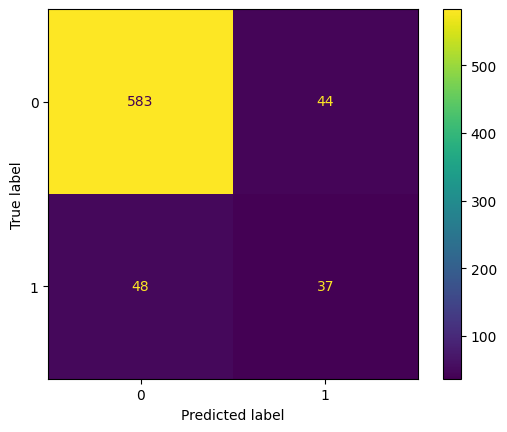

Max F1: 0.630048465266559 Threshold: 0.29219021509388987
Optimal threshold: 0.08546284415313282


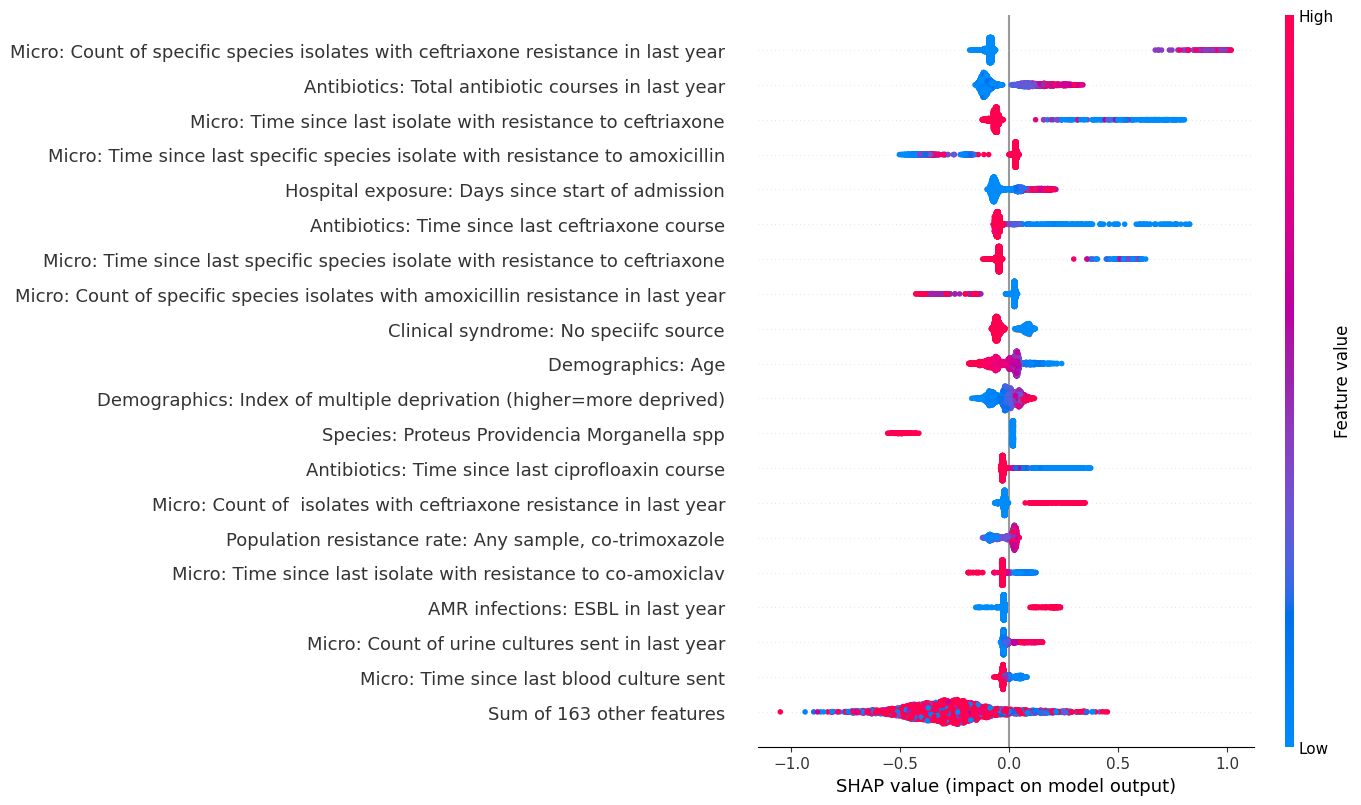

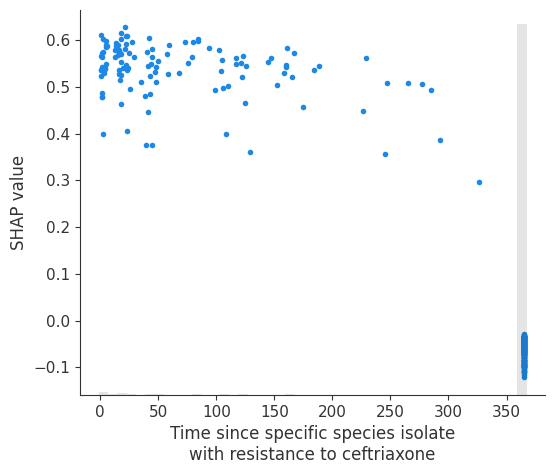

Scale pos weight: 7.99092970521542
100%|██████████| 100/100 [00:42<00:00,  2.36trial/s, best loss: -0.7600337365161209]
{'colsample_bytree': 0.45, 'gamma': 3, 'learning_rate': 0.002, 'max_depth': 4, 'min_child_weight': 3, 'n_estimators': 750, 'subsample': 0.6}
Baseline model performance (train):
('2X2 confusion matrix:', ['TP', np.int64(274), 'FP', np.int64(340), 'FN', np.int64(167), 'TN', np.int64(3184)], 'Accuracy:', np.float64(0.872), 'Balanced accuracy:', np.float64(0.762), 'Sensitivity/Recall:', np.float64(0.621), 'Specificity:', np.float64(0.904), 'PPV/Precision:', np.float64(0.446), 'NPV:', np.float64(0.95), 'F1-score:', np.float64(0.519), 'False positive rate:', np.float64(0.096), 'True positive rate:', np.float64(0.621), 'ROC AUC:', np.float64(0.867))
Baseline model performance (test):
('2X2 confusion matrix:', ['TP', np.int64(40), 'FP', np.int64(69), 'FN', np.int64(45), 'TN', np.int64(558)], 'Accuracy:', np.float64(0.84), 'Balanced accuracy:', np.float64(0.68), 'Sensitivity/R

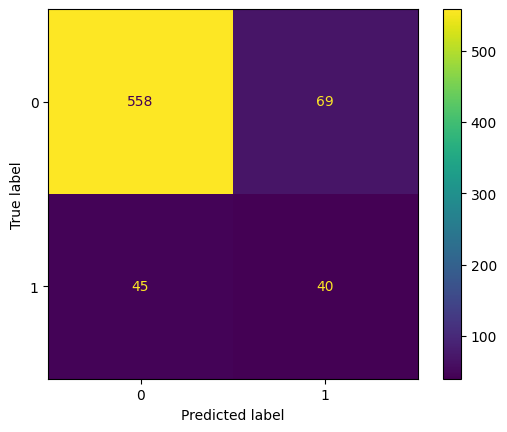

Time taken in seconds: 43
Test set 2
Max F1: 0.6245059288537549 Threshold: 0.27522077958892716
Optimal threshold: 0.12033962338588015
Performance with incremental update
Scale pos weight: 7.99092970521542
Time taken in seconds: 0
Baseline model performance (train):
('2X2 confusion matrix:', ['TP', np.int64(241), 'FP', np.int64(75), 'FN', np.int64(200), 'TN', np.int64(3449)], 'Accuracy:', np.float64(0.931), 'Balanced accuracy:', np.float64(0.763), 'Sensitivity/Recall:', np.float64(0.546), 'Specificity:', np.float64(0.979), 'PPV/Precision:', np.float64(0.763), 'NPV:', np.float64(0.945), 'F1-score:', np.float64(0.637), 'False positive rate:', np.float64(0.021), 'True positive rate:', np.float64(0.546), 'ROC AUC:', np.float64(0.874))
Baseline model performance (test):
('2X2 confusion matrix:', ['TP', np.int64(26), 'FP', np.int64(17), 'FN', np.int64(59), 'TN', np.int64(610)], 'Accuracy:', np.float64(0.893), 'Balanced accuracy:', np.float64(0.639), 'Sensitivity/Recall:', np.float64(0.306), '

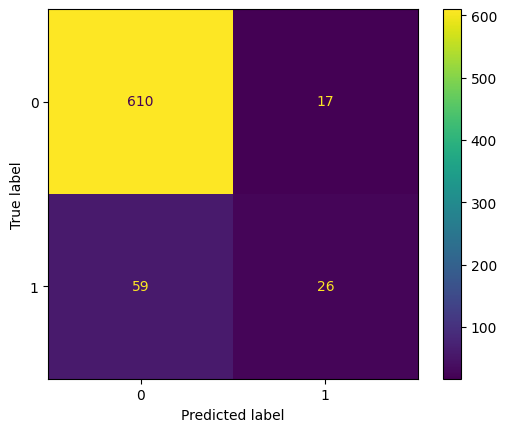

Max F1: 0.624 Threshold: 0.2817770078361843
Optimal threshold: 0.11820280563541848
ciprofloxacin
Index(['pt', 'index_dt', 'INFO_accessionnumber', 'INFO_bugname',
       'INFO_antibiotic', 'OUTCOME_ast_result', 'INFO_index_dt_since_baseline',
       'INDEX_DATE_index_dt_hour', 'INFO_BASELINE_ABX_baseline_abx',
       'INFO_BASELINE_ABX_last_betalactam',
       ...
       'MICRO_micro_sample_time_last_urine_365d',
       'MICRO_micro_sample_time_last_blood_365d',
       'MICRO_micro_positive_any_species_count_urine_365d',
       'MICRO_micro_positive_time_last_urine_365d',
       'MICRO_micro_positive_any_species_count_blood_365d',
       'MICRO_micro_positive_time_last_blood_365d',
       'MICRO_micro_positive_specific_species_count_urine_365d',
       'MICRO_micro_positive_specific_species_time_last_urine_365d',
       'MICRO_micro_positive_specific_species_count_blood_365d',
       'MICRO_micro_positive_specific_species_time_last_blood_365d'],
      dtype='object', length=180)
(4701, 

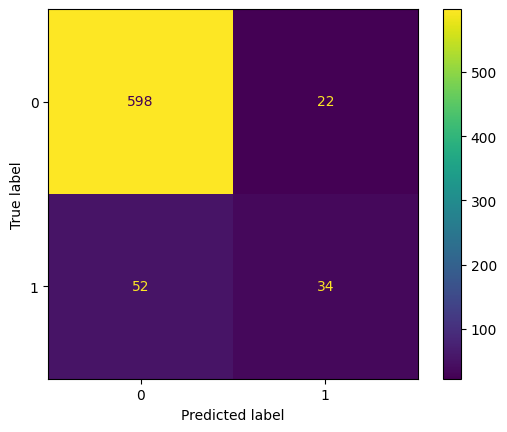

Time taken in seconds: 41
Test set 2
Baseline model performance (train):
('2X2 confusion matrix:', ['TP', np.int64(296), 'FP', np.int64(271), 'FN', np.int64(118), 'TN', np.int64(2590)], 'Accuracy:', np.float64(0.881), 'Balanced accuracy:', np.float64(0.81), 'Sensitivity/Recall:', np.float64(0.715), 'Specificity:', np.float64(0.905), 'PPV/Precision:', np.float64(0.522), 'NPV:', np.float64(0.956), 'F1-score:', np.float64(0.603), 'False positive rate:', np.float64(0.095), 'True positive rate:', np.float64(0.715), 'ROC AUC:', np.float64(0.907))
Baseline model performance (test):
('2X2 confusion matrix:', ['TP', np.int64(29), 'FP', np.int64(24), 'FN', np.int64(55), 'TN', np.int64(612)], 'Accuracy:', np.float64(0.89), 'Balanced accuracy:', np.float64(0.654), 'Sensitivity/Recall:', np.float64(0.345), 'Specificity:', np.float64(0.962), 'PPV/Precision:', np.float64(0.547), 'NPV:', np.float64(0.918), 'F1-score:', np.float64(0.423), 'False positive rate:', np.float64(0.038), 'True positive rate:'

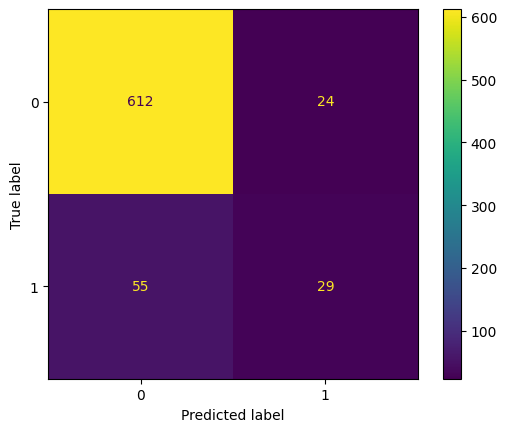

Max F1: 0.621773288439955 Threshold: 0.19288096531084595
Optimal threshold: 0.1238570808924303


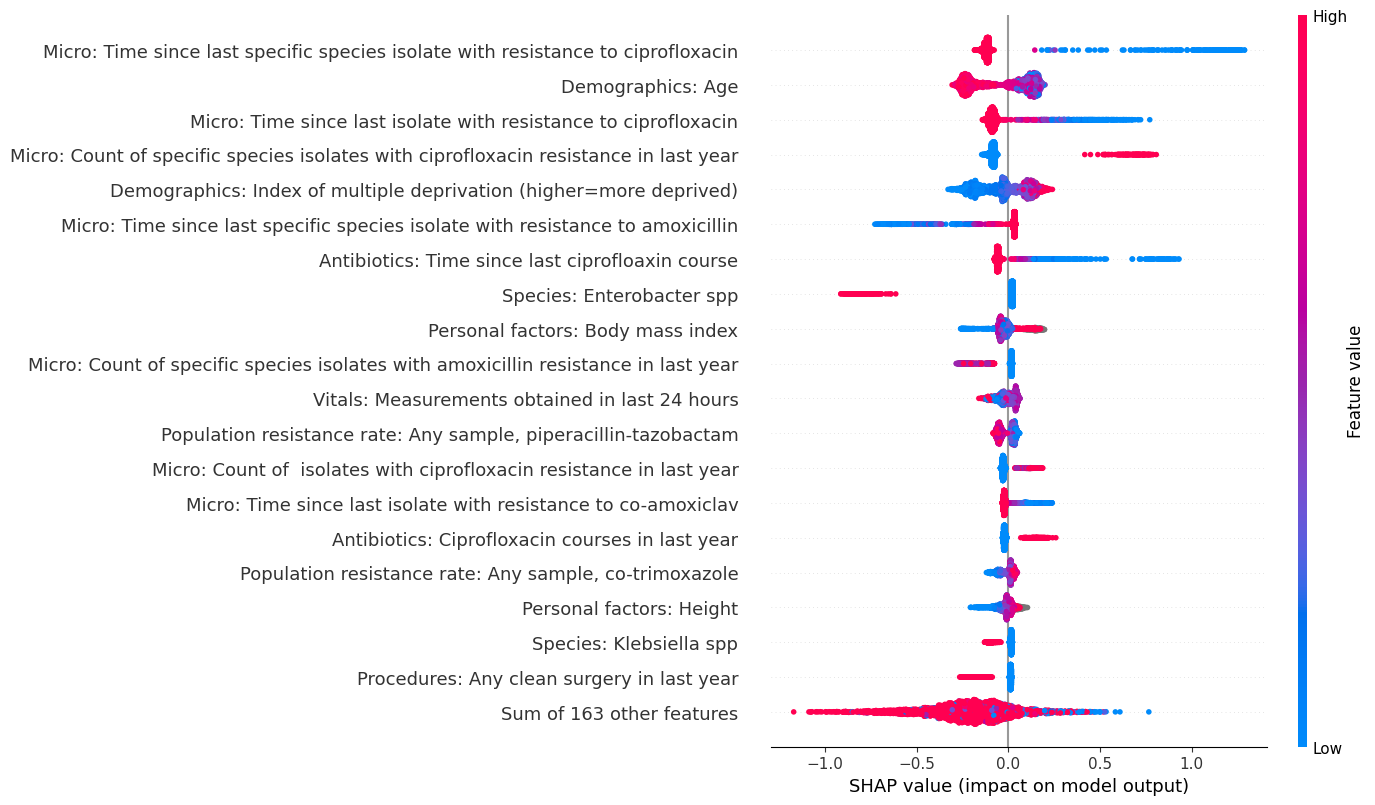

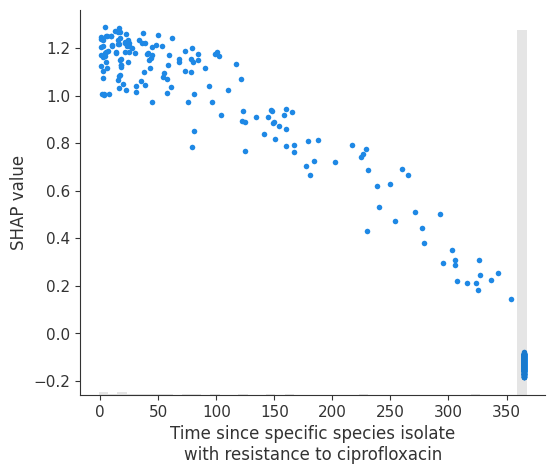

Scale pos weight: 6.962
100%|██████████| 100/100 [00:40<00:00,  2.46trial/s, best loss: -0.7402961020252814]
{'colsample_bytree': 0.35, 'gamma': 3, 'learning_rate': 0.002, 'max_depth': 5, 'min_child_weight': 7, 'n_estimators': 690, 'subsample': 0.6}
Baseline model performance (train):
('2X2 confusion matrix:', ['TP', np.int64(293), 'FP', np.int64(202), 'FN', np.int64(207), 'TN', np.int64(3279)], 'Accuracy:', np.float64(0.897), 'Balanced accuracy:', np.float64(0.764), 'Sensitivity/Recall:', np.float64(0.586), 'Specificity:', np.float64(0.942), 'PPV/Precision:', np.float64(0.592), 'NPV:', np.float64(0.941), 'F1-score:', np.float64(0.589), 'False positive rate:', np.float64(0.058), 'True positive rate:', np.float64(0.586), 'ROC AUC:', np.float64(0.888))
Baseline model performance (test):
('2X2 confusion matrix:', ['TP', np.int64(29), 'FP', np.int64(34), 'FN', np.int64(55), 'TN', np.int64(602)], 'Accuracy:', np.float64(0.876), 'Balanced accuracy:', np.float64(0.646), 'Sensitivity/Recall:',

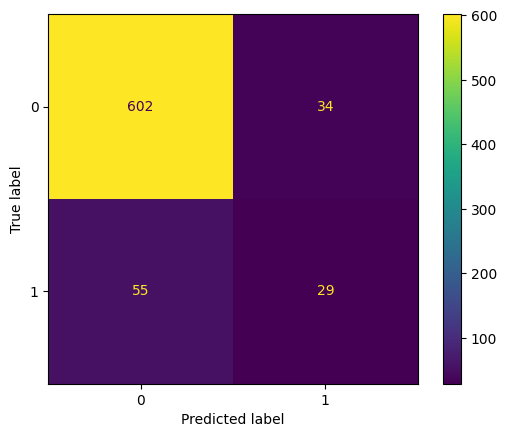

Time taken in seconds: 42
Test set 2
Max F1: 0.6191950464396285 Threshold: 0.2170401133992803
Optimal threshold: 0.12808657792302441
Performance with incremental update
Scale pos weight: 6.962
Time taken in seconds: 1
Baseline model performance (train):
('2X2 confusion matrix:', ['TP', np.int64(336), 'FP', np.int64(394), 'FN', np.int64(164), 'TN', np.int64(3087)], 'Accuracy:', np.float64(0.86), 'Balanced accuracy:', np.float64(0.779), 'Sensitivity/Recall:', np.float64(0.672), 'Specificity:', np.float64(0.887), 'PPV/Precision:', np.float64(0.46), 'NPV:', np.float64(0.95), 'F1-score:', np.float64(0.546), 'False positive rate:', np.float64(0.113), 'True positive rate:', np.float64(0.672), 'ROC AUC:', np.float64(0.87))
Baseline model performance (test):
('2X2 confusion matrix:', ['TP', np.int64(30), 'FP', np.int64(66), 'FN', np.int64(54), 'TN', np.int64(570)], 'Accuracy:', np.float64(0.833), 'Balanced accuracy:', np.float64(0.627), 'Sensitivity/Recall:', np.float64(0.357), 'Specificity:', 

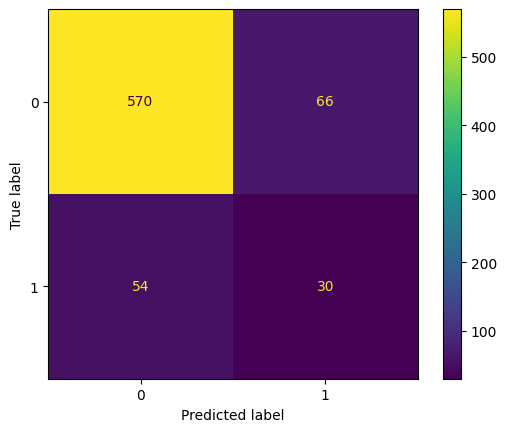

Max F1: 0.6182190378710337 Threshold: 0.21418036351727526
Optimal threshold: 0.12820101255042352
co-amoxiclav
Index(['pt', 'index_dt', 'INFO_accessionnumber', 'INFO_bugname',
       'INFO_antibiotic', 'OUTCOME_ast_result', 'INFO_index_dt_since_baseline',
       'INDEX_DATE_index_dt_hour', 'INFO_BASELINE_ABX_baseline_abx',
       'INFO_BASELINE_ABX_last_betalactam',
       ...
       'MICRO_micro_sample_time_last_urine_365d',
       'MICRO_micro_sample_time_last_blood_365d',
       'MICRO_micro_positive_any_species_count_urine_365d',
       'MICRO_micro_positive_time_last_urine_365d',
       'MICRO_micro_positive_any_species_count_blood_365d',
       'MICRO_micro_positive_time_last_blood_365d',
       'MICRO_micro_positive_specific_species_count_urine_365d',
       'MICRO_micro_positive_specific_species_time_last_urine_365d',
       'MICRO_micro_positive_specific_species_count_blood_365d',
       'MICRO_micro_positive_specific_species_time_last_blood_365d'],
      dtype='object', length

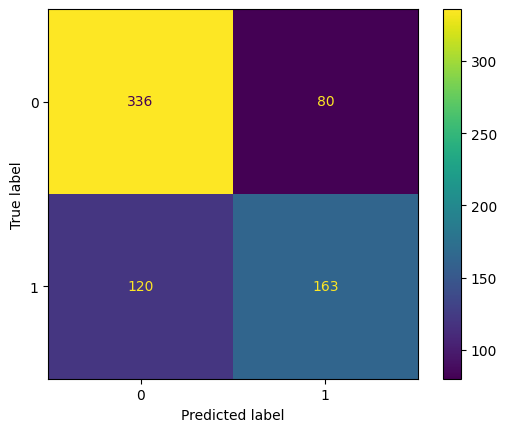

Time taken in seconds: 69
Test set 2
Baseline model performance (train):
('2X2 confusion matrix:', ['TP', np.int64(829), 'FP', np.int64(239), 'FN', np.int64(548), 'TN', np.int64(1641)], 'Accuracy:', np.float64(0.758), 'Balanced accuracy:', np.float64(0.737), 'Sensitivity/Recall:', np.float64(0.602), 'Specificity:', np.float64(0.873), 'PPV/Precision:', np.float64(0.776), 'NPV:', np.float64(0.75), 'F1-score:', np.float64(0.678), 'False positive rate:', np.float64(0.127), 'True positive rate:', np.float64(0.602), 'ROC AUC:', np.float64(0.822))
Baseline model performance (test):
('2X2 confusion matrix:', ['TP', np.int64(119), 'FP', np.int64(80), 'FN', np.int64(126), 'TN', np.int64(385)], 'Accuracy:', np.float64(0.71), 'Balanced accuracy:', np.float64(0.657), 'Sensitivity/Recall:', np.float64(0.486), 'Specificity:', np.float64(0.828), 'PPV/Precision:', np.float64(0.598), 'NPV:', np.float64(0.753), 'F1-score:', np.float64(0.536), 'False positive rate:', np.float64(0.172), 'True positive rate

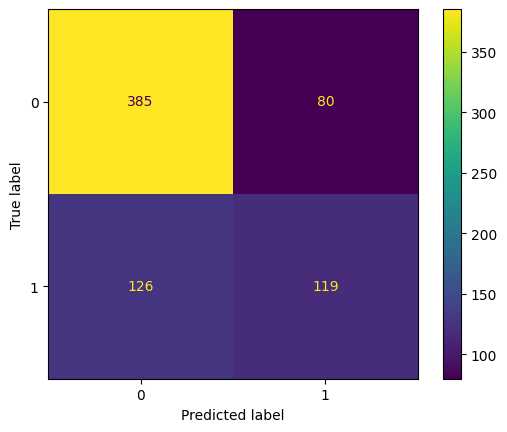

Max F1: 0.6984347826086957 Threshold: 0.346829697282658
Optimal threshold: 0.37894662863614137


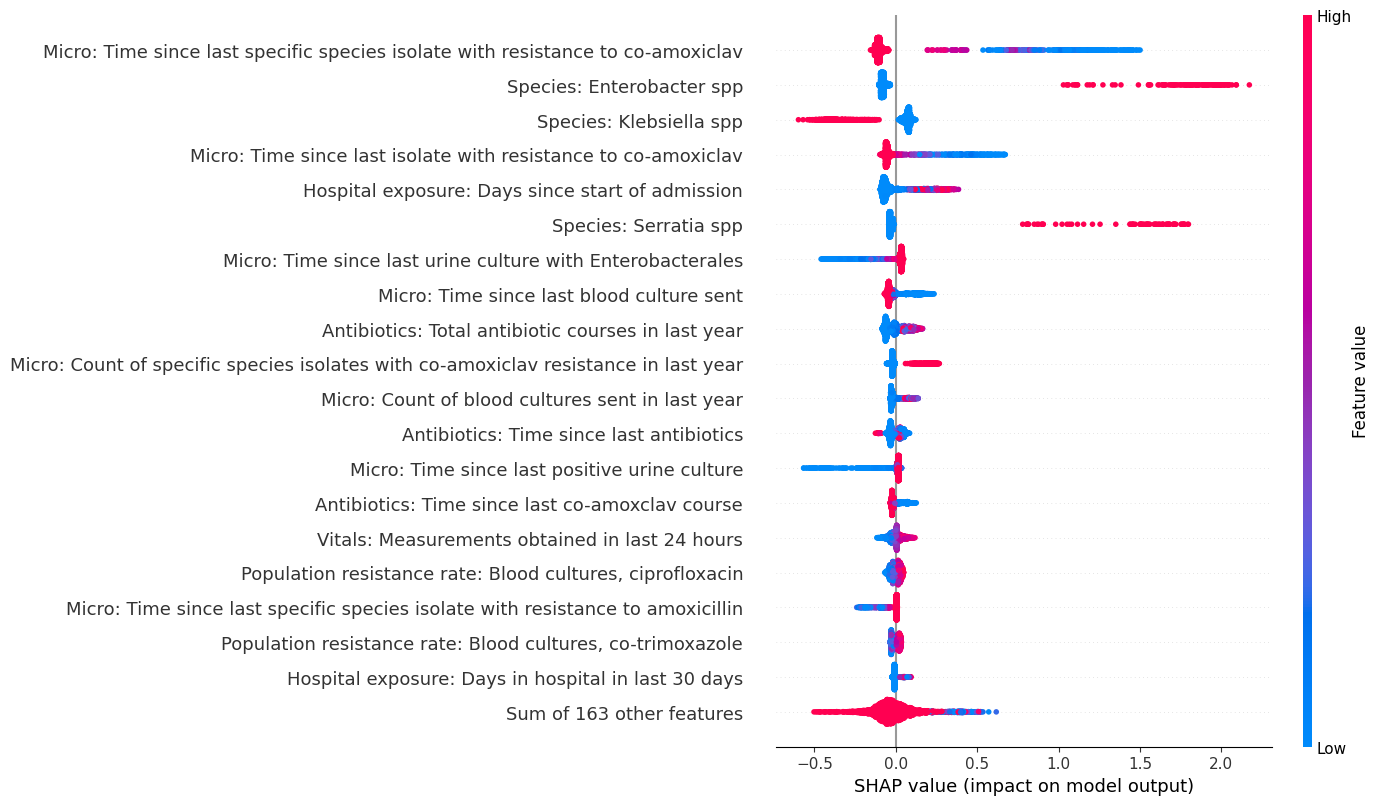

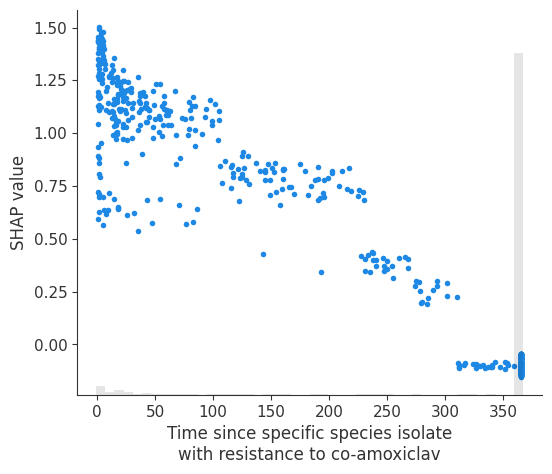

Scale pos weight: 1.383132530120482
100%|██████████| 100/100 [01:12<00:00,  1.39trial/s, best loss: -0.754439106607238]
{'colsample_bytree': 0.45, 'gamma': 1, 'learning_rate': 0.005, 'max_depth': 4, 'min_child_weight': 6, 'n_estimators': 730, 'subsample': 0.6}
Baseline model performance (train):
('2X2 confusion matrix:', ['TP', np.int64(968), 'FP', np.int64(288), 'FN', np.int64(692), 'TN', np.int64(2008)], 'Accuracy:', np.float64(0.752), 'Balanced accuracy:', np.float64(0.729), 'Sensitivity/Recall:', np.float64(0.583), 'Specificity:', np.float64(0.875), 'PPV/Precision:', np.float64(0.771), 'NPV:', np.float64(0.744), 'F1-score:', np.float64(0.664), 'False positive rate:', np.float64(0.125), 'True positive rate:', np.float64(0.583), 'ROC AUC:', np.float64(0.814))
Baseline model performance (test):
('2X2 confusion matrix:', ['TP', np.int64(119), 'FP', np.int64(77), 'FN', np.int64(126), 'TN', np.int64(388)], 'Accuracy:', np.float64(0.714), 'Balanced accuracy:', np.float64(0.66), 'Sensitivi

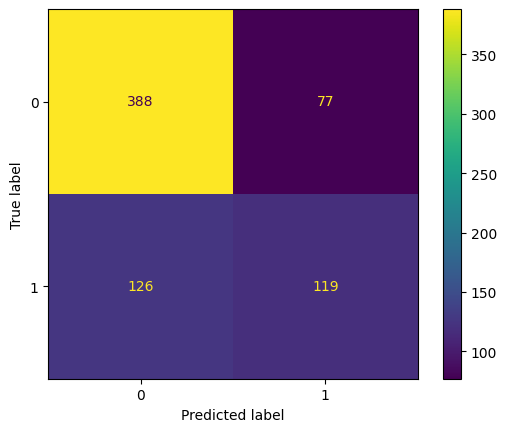

Time taken in seconds: 73
Test set 2
Max F1: 0.6955510322768247 Threshold: 0.34626765636412016
Optimal threshold: 0.4154361938022987
Performance with incremental update
Scale pos weight: 1.383132530120482
Time taken in seconds: 0
Baseline model performance (train):
('2X2 confusion matrix:', ['TP', np.int64(931), 'FP', np.int64(271), 'FN', np.int64(729), 'TN', np.int64(2025)], 'Accuracy:', np.float64(0.747), 'Balanced accuracy:', np.float64(0.721), 'Sensitivity/Recall:', np.float64(0.561), 'Specificity:', np.float64(0.882), 'PPV/Precision:', np.float64(0.775), 'NPV:', np.float64(0.735), 'F1-score:', np.float64(0.651), 'False positive rate:', np.float64(0.118), 'True positive rate:', np.float64(0.561), 'ROC AUC:', np.float64(0.813))
Baseline model performance (test):
('2X2 confusion matrix:', ['TP', np.int64(121), 'FP', np.int64(81), 'FN', np.int64(124), 'TN', np.int64(384)], 'Accuracy:', np.float64(0.711), 'Balanced accuracy:', np.float64(0.66), 'Sensitivity/Recall:', np.float64(0.494),

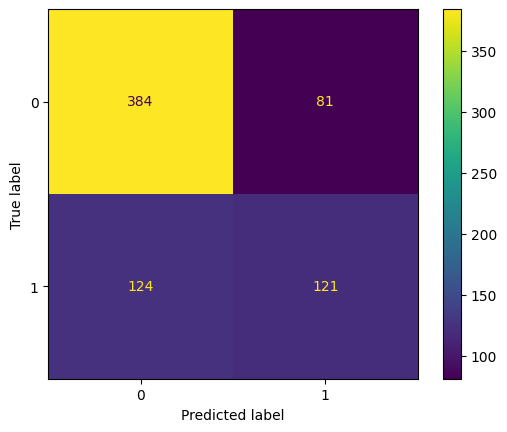

Max F1: 0.6961876832844575 Threshold: 0.35058417169868905
Optimal threshold: 0.4181956790561017
co-trimoxazole
Index(['pt', 'index_dt', 'INFO_accessionnumber', 'INFO_bugname',
       'INFO_antibiotic', 'OUTCOME_ast_result', 'INFO_index_dt_since_baseline',
       'INDEX_DATE_index_dt_hour', 'INFO_BASELINE_ABX_baseline_abx',
       'INFO_BASELINE_ABX_last_betalactam',
       ...
       'MICRO_micro_sample_time_last_urine_365d',
       'MICRO_micro_sample_time_last_blood_365d',
       'MICRO_micro_positive_any_species_count_urine_365d',
       'MICRO_micro_positive_time_last_urine_365d',
       'MICRO_micro_positive_any_species_count_blood_365d',
       'MICRO_micro_positive_time_last_blood_365d',
       'MICRO_micro_positive_specific_species_count_urine_365d',
       'MICRO_micro_positive_specific_species_time_last_urine_365d',
       'MICRO_micro_positive_specific_species_count_blood_365d',
       'MICRO_micro_positive_specific_species_time_last_blood_365d'],
      dtype='object', lengt

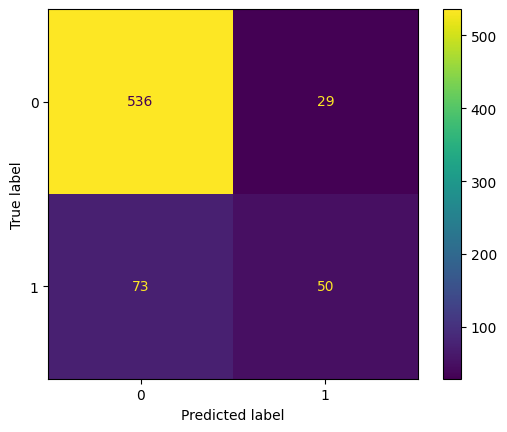

Time taken in seconds: 74
Test set 2
Baseline model performance (train):
('2X2 confusion matrix:', ['TP', np.int64(534), 'FP', np.int64(166), 'FN', np.int64(227), 'TN', np.int64(2275)], 'Accuracy:', np.float64(0.877), 'Balanced accuracy:', np.float64(0.817), 'Sensitivity/Recall:', np.float64(0.702), 'Specificity:', np.float64(0.932), 'PPV/Precision:', np.float64(0.763), 'NPV:', np.float64(0.909), 'F1-score:', np.float64(0.731), 'False positive rate:', np.float64(0.068), 'True positive rate:', np.float64(0.702), 'ROC AUC:', np.float64(0.927))
Baseline model performance (test):
('2X2 confusion matrix:', ['TP', np.int64(46), 'FP', np.int64(43), 'FN', np.int64(81), 'TN', np.int64(533)], 'Accuracy:', np.float64(0.824), 'Balanced accuracy:', np.float64(0.644), 'Sensitivity/Recall:', np.float64(0.362), 'Specificity:', np.float64(0.925), 'PPV/Precision:', np.float64(0.517), 'NPV:', np.float64(0.868), 'F1-score:', np.float64(0.426), 'False positive rate:', np.float64(0.075), 'True positive rate

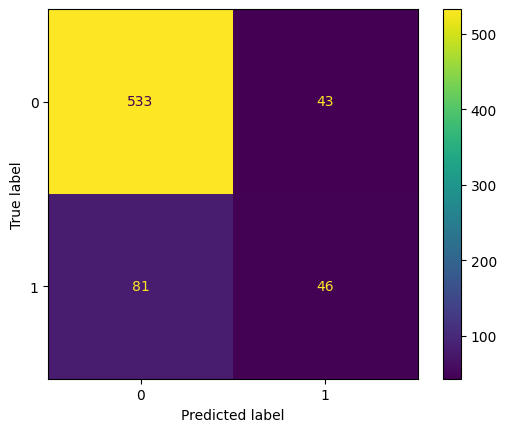

Max F1: 0.7415307402760352 Threshold: 0.27252114697734553
Optimal threshold: 0.23870781903504437


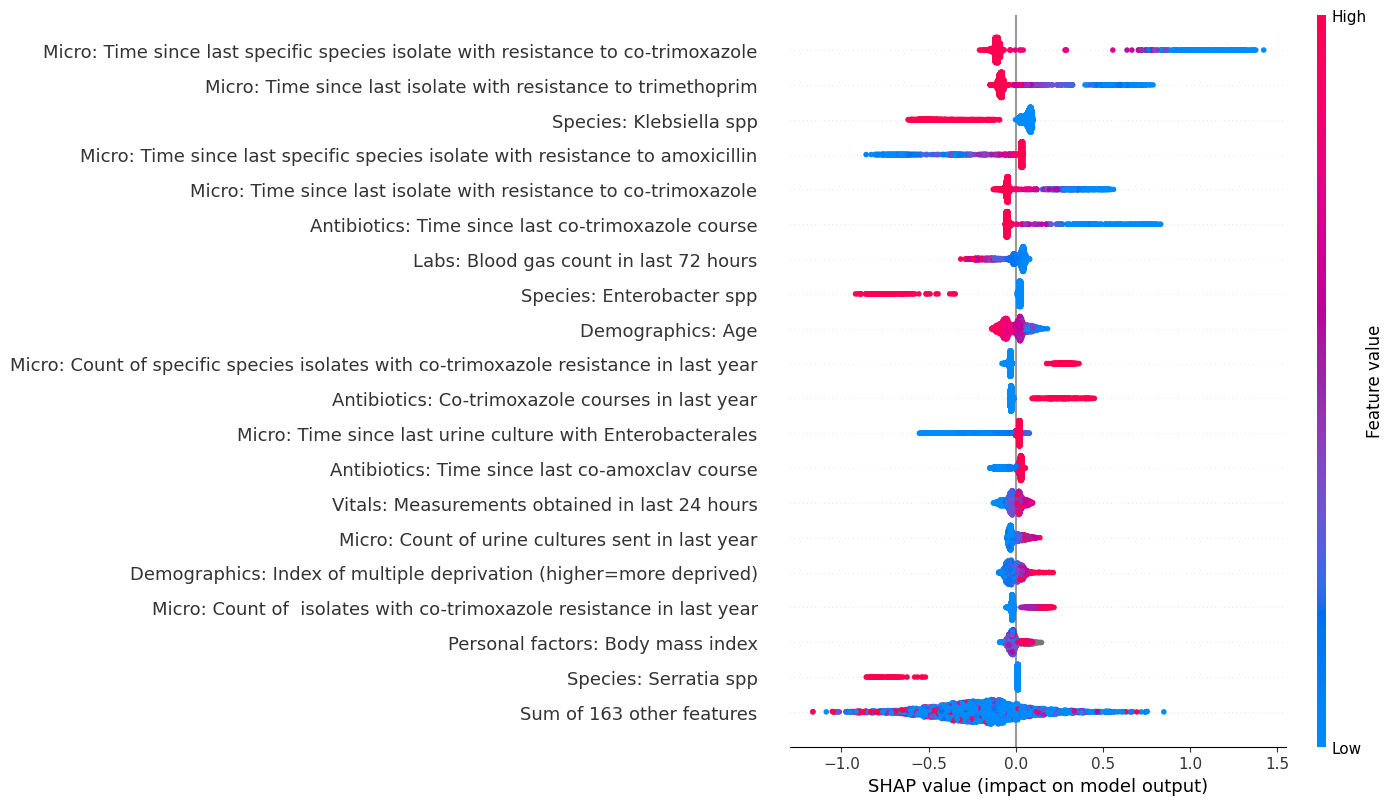

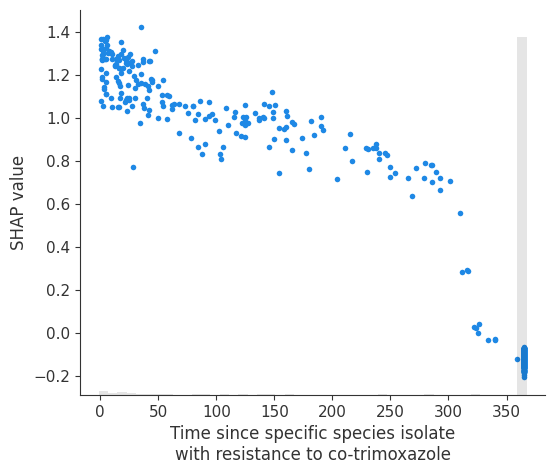

Scale pos weight: 3.4004524886877827
100%|██████████| 100/100 [01:08<00:00,  1.45trial/s, best loss: -0.7419101793016895]
{'colsample_bytree': 0.25, 'gamma': 6, 'learning_rate': 0.005, 'max_depth': 11, 'min_child_weight': 4, 'n_estimators': 1210, 'subsample': 0.6}
Baseline model performance (train):
('2X2 confusion matrix:', ['TP', np.int64(798), 'FP', np.int64(166), 'FN', np.int64(86), 'TN', np.int64(2840)], 'Accuracy:', np.float64(0.935), 'Balanced accuracy:', np.float64(0.924), 'Sensitivity/Recall:', np.float64(0.903), 'Specificity:', np.float64(0.945), 'PPV/Precision:', np.float64(0.828), 'NPV:', np.float64(0.971), 'F1-score:', np.float64(0.864), 'False positive rate:', np.float64(0.055), 'True positive rate:', np.float64(0.903), 'ROC AUC:', np.float64(0.973))
Baseline model performance (test):
('2X2 confusion matrix:', ['TP', np.int64(48), 'FP', np.int64(36), 'FN', np.int64(79), 'TN', np.int64(540)], 'Accuracy:', np.float64(0.836), 'Balanced accuracy:', np.float64(0.658), 'Sensiti

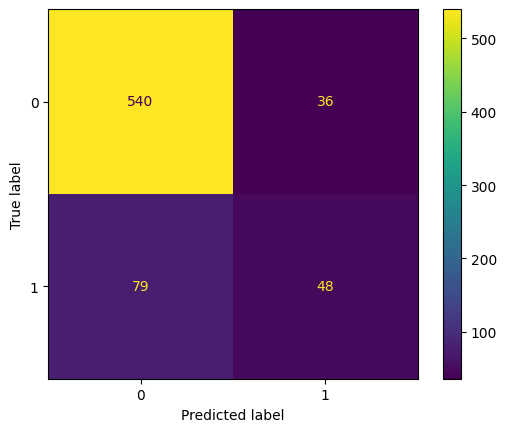

Time taken in seconds: 72
Test set 2
Max F1: 0.7277327935222672 Threshold: 0.2463795330906382
Optimal threshold: 0.23125591989553862
Performance with incremental update
Scale pos weight: 3.4004524886877827
Time taken in seconds: 3
Baseline model performance (train):
('2X2 confusion matrix:', ['TP', np.int64(496), 'FP', np.int64(156), 'FN', np.int64(388), 'TN', np.int64(2850)], 'Accuracy:', np.float64(0.86), 'Balanced accuracy:', np.float64(0.755), 'Sensitivity/Recall:', np.float64(0.561), 'Specificity:', np.float64(0.948), 'PPV/Precision:', np.float64(0.761), 'NPV:', np.float64(0.88), 'F1-score:', np.float64(0.646), 'False positive rate:', np.float64(0.052), 'True positive rate:', np.float64(0.561), 'ROC AUC:', np.float64(0.871))
Baseline model performance (test):
('2X2 confusion matrix:', ['TP', np.int64(49), 'FP', np.int64(40), 'FN', np.int64(78), 'TN', np.int64(536)], 'Accuracy:', np.float64(0.832), 'Balanced accuracy:', np.float64(0.658), 'Sensitivity/Recall:', np.float64(0.386), '

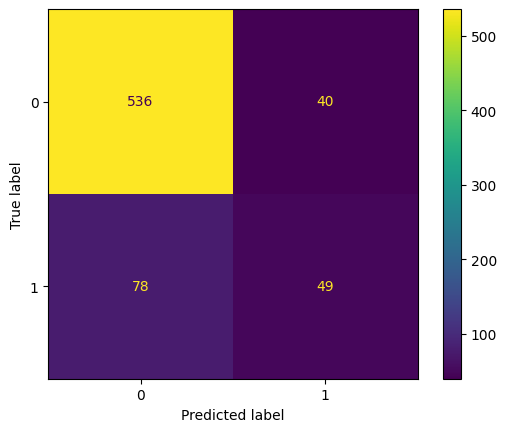

Max F1: 0.7291346646185356 Threshold: 0.25215606786339523
Optimal threshold: 0.24200345007157456
gentamicin
Index(['pt', 'index_dt', 'INFO_accessionnumber', 'INFO_bugname',
       'INFO_antibiotic', 'OUTCOME_ast_result', 'INFO_index_dt_since_baseline',
       'INDEX_DATE_index_dt_hour', 'INFO_BASELINE_ABX_baseline_abx',
       'INFO_BASELINE_ABX_last_betalactam',
       ...
       'MICRO_micro_sample_time_last_urine_365d',
       'MICRO_micro_sample_time_last_blood_365d',
       'MICRO_micro_positive_any_species_count_urine_365d',
       'MICRO_micro_positive_time_last_urine_365d',
       'MICRO_micro_positive_any_species_count_blood_365d',
       'MICRO_micro_positive_time_last_blood_365d',
       'MICRO_micro_positive_specific_species_count_urine_365d',
       'MICRO_micro_positive_specific_species_time_last_urine_365d',
       'MICRO_micro_positive_specific_species_count_blood_365d',
       'MICRO_micro_positive_specific_species_time_last_blood_365d'],
      dtype='object', length=1

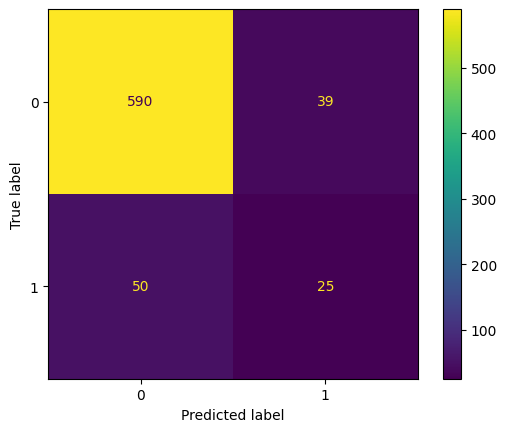

Time taken in seconds: 39
Test set 2
Baseline model performance (train):
('2X2 confusion matrix:', ['TP', np.int64(182), 'FP', np.int64(176), 'FN', np.int64(125), 'TN', np.int64(2783)], 'Accuracy:', np.float64(0.908), 'Balanced accuracy:', np.float64(0.767), 'Sensitivity/Recall:', np.float64(0.593), 'Specificity:', np.float64(0.941), 'PPV/Precision:', np.float64(0.508), 'NPV:', np.float64(0.957), 'F1-score:', np.float64(0.547), 'False positive rate:', np.float64(0.059), 'True positive rate:', np.float64(0.593), 'ROC AUC:', np.float64(0.881))
Baseline model performance (test):
('2X2 confusion matrix:', ['TP', np.int64(33), 'FP', np.int64(36), 'FN', np.int64(46), 'TN', np.int64(600)], 'Accuracy:', np.float64(0.885), 'Balanced accuracy:', np.float64(0.681), 'Sensitivity/Recall:', np.float64(0.418), 'Specificity:', np.float64(0.943), 'PPV/Precision:', np.float64(0.478), 'NPV:', np.float64(0.929), 'F1-score:', np.float64(0.446), 'False positive rate:', np.float64(0.057), 'True positive rate

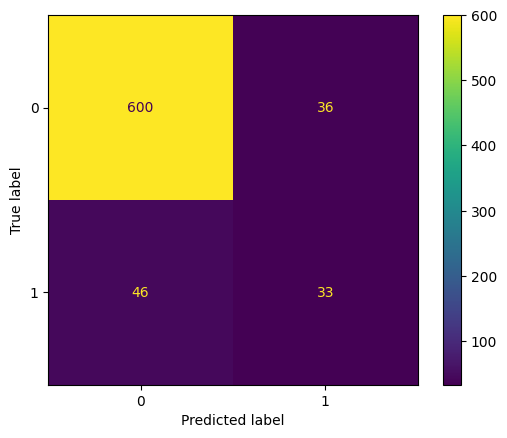

Max F1: 0.5466034755134281 Threshold: 0.14835543835130788
Optimal threshold: 0.08671050053946176


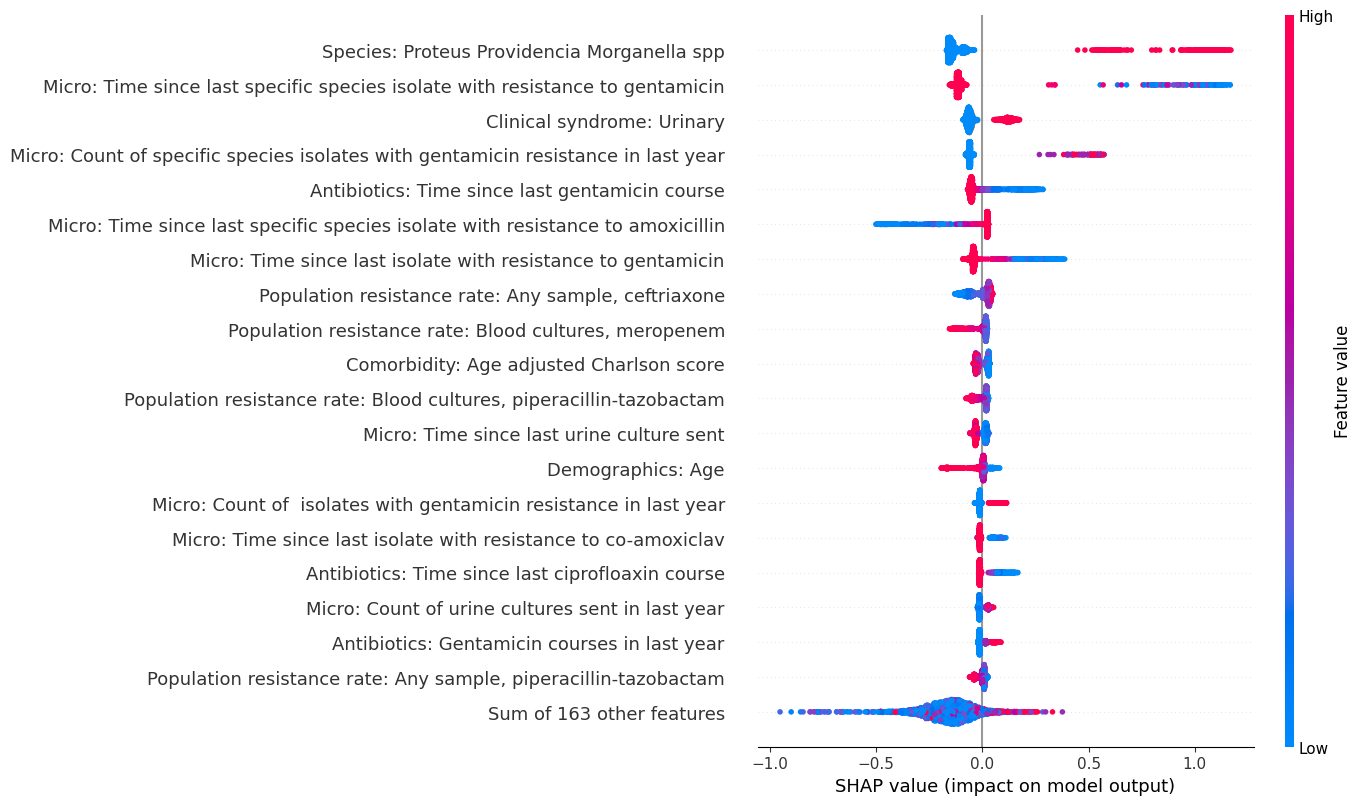

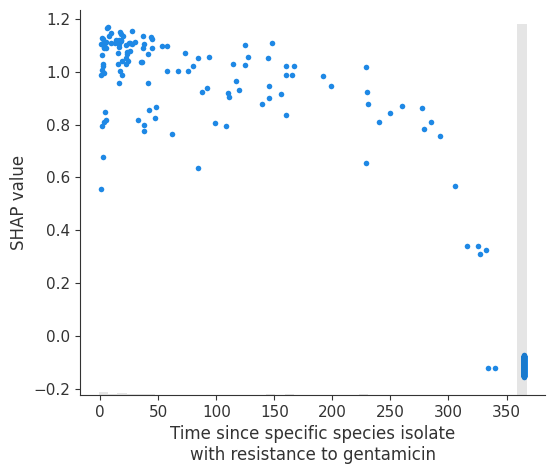

Scale pos weight: 9.392670157068062
100%|██████████| 100/100 [00:40<00:00,  2.49trial/s, best loss: -0.7586911703261995]
{'colsample_bytree': 0.65, 'gamma': 5, 'learning_rate': 0.005, 'max_depth': 5, 'min_child_weight': 7, 'n_estimators': 750, 'subsample': 0.7}
Baseline model performance (train):
('2X2 confusion matrix:', ['TP', np.int64(281), 'FP', np.int64(157), 'FN', np.int64(101), 'TN', np.int64(3431)], 'Accuracy:', np.float64(0.935), 'Balanced accuracy:', np.float64(0.846), 'Sensitivity/Recall:', np.float64(0.736), 'Specificity:', np.float64(0.956), 'PPV/Precision:', np.float64(0.642), 'NPV:', np.float64(0.971), 'F1-score:', np.float64(0.685), 'False positive rate:', np.float64(0.044), 'True positive rate:', np.float64(0.736), 'ROC AUC:', np.float64(0.959))
Baseline model performance (test):
('2X2 confusion matrix:', ['TP', np.int64(34), 'FP', np.int64(54), 'FN', np.int64(45), 'TN', np.int64(582)], 'Accuracy:', np.float64(0.862), 'Balanced accuracy:', np.float64(0.673), 'Sensitivi

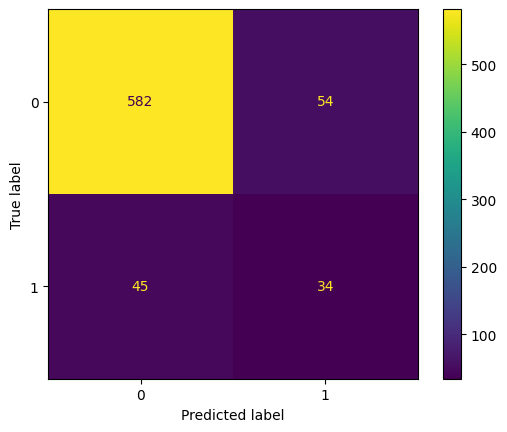

Time taken in seconds: 42
Test set 2
Max F1: 0.5400516795865633 Threshold: 0.17139589570270788
Optimal threshold: 0.08050073749292083
Performance with incremental update
Scale pos weight: 9.392670157068062
Time taken in seconds: 0
Baseline model performance (train):
('2X2 confusion matrix:', ['TP', np.int64(256), 'FP', np.int64(414), 'FN', np.int64(126), 'TN', np.int64(3174)], 'Accuracy:', np.float64(0.864), 'Balanced accuracy:', np.float64(0.777), 'Sensitivity/Recall:', np.float64(0.67), 'Specificity:', np.float64(0.885), 'PPV/Precision:', np.float64(0.382), 'NPV:', np.float64(0.962), 'F1-score:', np.float64(0.487), 'False positive rate:', np.float64(0.115), 'True positive rate:', np.float64(0.67), 'ROC AUC:', np.float64(0.856))
Baseline model performance (test):
('2X2 confusion matrix:', ['TP', np.int64(37), 'FP', np.int64(68), 'FN', np.int64(42), 'TN', np.int64(568)], 'Accuracy:', np.float64(0.846), 'Balanced accuracy:', np.float64(0.681), 'Sensitivity/Recall:', np.float64(0.468), '

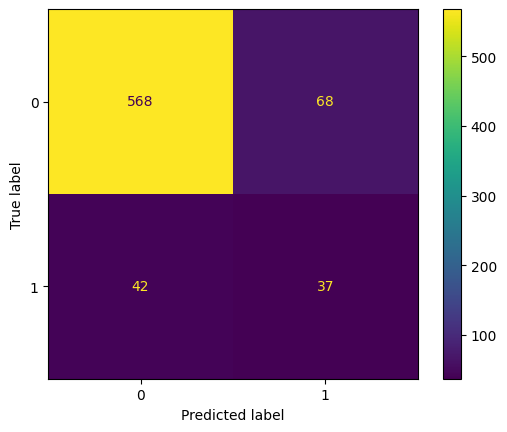

Max F1: 0.5400516795865633 Threshold: 0.1708424809370408
Optimal threshold: 0.08246195194750473
piperacillin-tazobactam
Index(['pt', 'index_dt', 'INFO_accessionnumber', 'INFO_bugname',
       'INFO_antibiotic', 'OUTCOME_ast_result', 'INFO_index_dt_since_baseline',
       'INDEX_DATE_index_dt_hour', 'INFO_BASELINE_ABX_baseline_abx',
       'INFO_BASELINE_ABX_last_betalactam',
       ...
       'MICRO_micro_sample_time_last_urine_365d',
       'MICRO_micro_sample_time_last_blood_365d',
       'MICRO_micro_positive_any_species_count_urine_365d',
       'MICRO_micro_positive_time_last_urine_365d',
       'MICRO_micro_positive_any_species_count_blood_365d',
       'MICRO_micro_positive_time_last_blood_365d',
       'MICRO_micro_positive_specific_species_count_urine_365d',
       'MICRO_micro_positive_specific_species_time_last_urine_365d',
       'MICRO_micro_positive_specific_species_count_blood_365d',
       'MICRO_micro_positive_specific_species_time_last_blood_365d'],
      dtype='objec

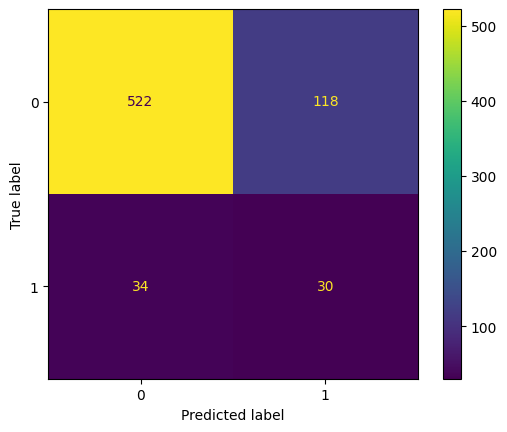

Time taken in seconds: 41
Test set 2
Baseline model performance (train):
('2X2 confusion matrix:', ['TP', np.int64(161), 'FP', np.int64(400), 'FN', np.int64(53), 'TN', np.int64(2659)], 'Accuracy:', np.float64(0.862), 'Balanced accuracy:', np.float64(0.811), 'Sensitivity/Recall:', np.float64(0.752), 'Specificity:', np.float64(0.869), 'PPV/Precision:', np.float64(0.287), 'NPV:', np.float64(0.98), 'F1-score:', np.float64(0.415), 'False positive rate:', np.float64(0.131), 'True positive rate:', np.float64(0.752), 'ROC AUC:', np.float64(0.901))
Baseline model performance (test):
('2X2 confusion matrix:', ['TP', np.int64(25), 'FP', np.int64(126), 'FN', np.int64(38), 'TN', np.int64(525)], 'Accuracy:', np.float64(0.77), 'Balanced accuracy:', np.float64(0.602), 'Sensitivity/Recall:', np.float64(0.397), 'Specificity:', np.float64(0.806), 'PPV/Precision:', np.float64(0.166), 'NPV:', np.float64(0.933), 'F1-score:', np.float64(0.234), 'False positive rate:', np.float64(0.194), 'True positive rate:'

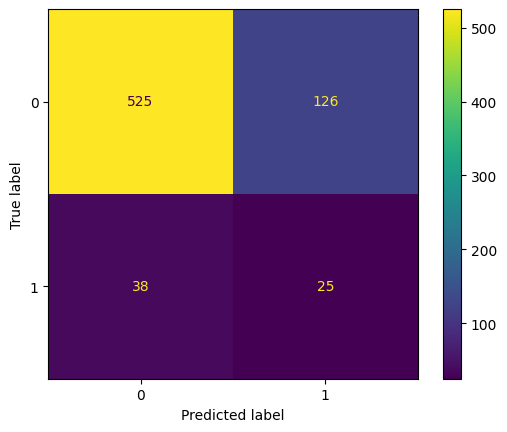

Max F1: 0.5239179954441913 Threshold: 0.22431175840458756
Optimal threshold: 0.06861211366079295


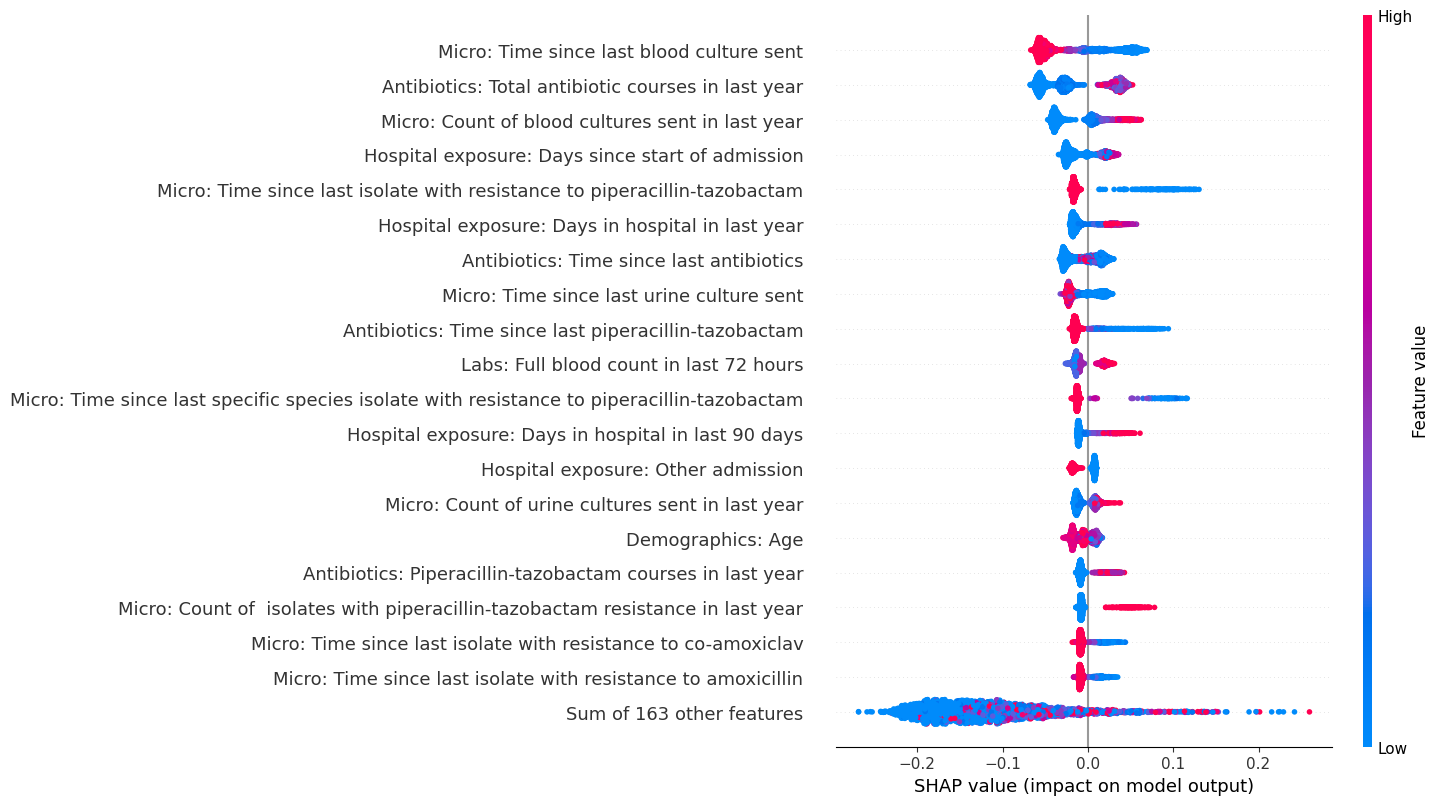

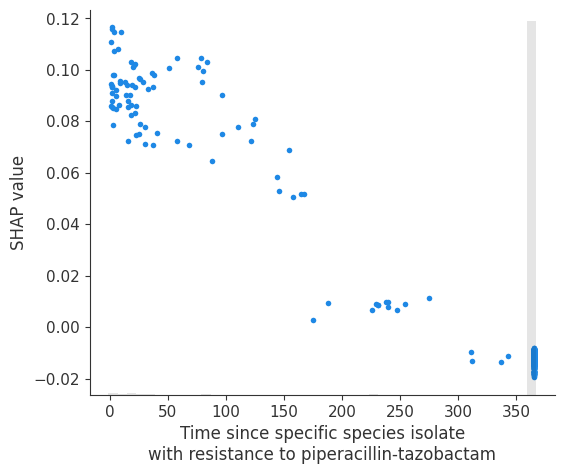

Scale pos weight: 13.305755395683454
100%|██████████| 100/100 [00:40<00:00,  2.46trial/s, best loss: -0.8078666928610172]
{'colsample_bytree': 0.75, 'gamma': 3, 'learning_rate': 0.005, 'max_depth': 3, 'min_child_weight': 7, 'n_estimators': 550, 'subsample': 0.6}
Baseline model performance (train):
('2X2 confusion matrix:', ['TP', np.int64(213), 'FP', np.int64(619), 'FN', np.int64(65), 'TN', np.int64(3080)], 'Accuracy:', np.float64(0.828), 'Balanced accuracy:', np.float64(0.799), 'Sensitivity/Recall:', np.float64(0.766), 'Specificity:', np.float64(0.833), 'PPV/Precision:', np.float64(0.256), 'NPV:', np.float64(0.979), 'F1-score:', np.float64(0.384), 'False positive rate:', np.float64(0.167), 'True positive rate:', np.float64(0.766), 'ROC AUC:', np.float64(0.891))
Baseline model performance (test):
('2X2 confusion matrix:', ['TP', np.int64(33), 'FP', np.int64(150), 'FN', np.int64(30), 'TN', np.int64(501)], 'Accuracy:', np.float64(0.748), 'Balanced accuracy:', np.float64(0.647), 'Sensitiv

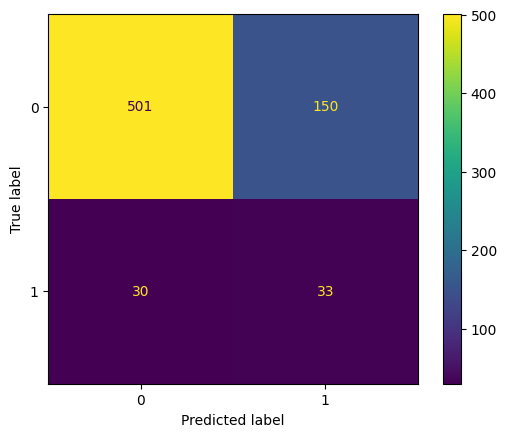

Time taken in seconds: 41
Test set 2
Max F1: 0.5053995680345572 Threshold: 0.2938152695339302
Optimal threshold: 0.06500313214500582
Performance with incremental update
Scale pos weight: 13.305755395683454
Time taken in seconds: 0
Baseline model performance (train):
('2X2 confusion matrix:', ['TP', np.int64(178), 'FP', np.int64(327), 'FN', np.int64(100), 'TN', np.int64(3372)], 'Accuracy:', np.float64(0.893), 'Balanced accuracy:', np.float64(0.776), 'Sensitivity/Recall:', np.float64(0.64), 'Specificity:', np.float64(0.912), 'PPV/Precision:', np.float64(0.352), 'NPV:', np.float64(0.971), 'F1-score:', np.float64(0.455), 'False positive rate:', np.float64(0.088), 'True positive rate:', np.float64(0.64), 'ROC AUC:', np.float64(0.883))
Baseline model performance (test):
('2X2 confusion matrix:', ['TP', np.int64(24), 'FP', np.int64(95), 'FN', np.int64(39), 'TN', np.int64(556)], 'Accuracy:', np.float64(0.812), 'Balanced accuracy:', np.float64(0.618), 'Sensitivity/Recall:', np.float64(0.381), '

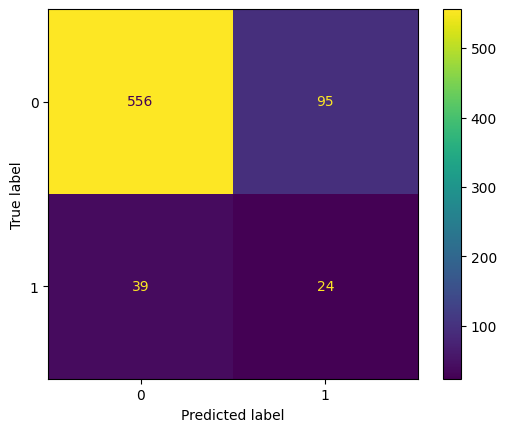

Max F1: 0.5054466230936819 Threshold: 0.2994281863361274
Optimal threshold: 0.06388144077021467


In [1417]:

abx_list = ['amoxicillin', 'ceftriaxone',
                        'ciprofloxacin', 'co-amoxiclav', 'co-trimoxazole', 'gentamicin', 
                     'piperacillin-tazobactam']
# abx_list = ['amoxicillin']

# create empty dataframe to store training time by antibiotic, species and training data
df_time = []

for species_i in [0, 1]:
    for abx_i in abx_list:
        print(abx_i)
        
        # load data
        if species_i == 0:
            filename = '../ehr_dataset_maker/exports/refined_extract_abx_choice_%s.csv'%abx_i
        else:
            filename = '../ehr_dataset_maker/exports/refined_extract_abx_choice_%s_species.csv'%abx_i
        
        (train_y, train_x, train_extended_y, train_extended_x, test_y, test_x, test2_y, test2_x, colnames, df_train_raw, 
         df_train_extended_raw, df_test1_raw, df_test2_raw) = load_data(filename, species_i)
        scale_pos = scale_pos_weight(train_y)
        
        # Hyperparameter tuning based model and time how long takes
        time_now = pd.Timestamp.now()
        xgb_optim, best_param = optimized_model(train_x, train_y, test_x, test_y, scale_pos, trials=Trials(), max_evals=HYPERPARAMETER_TUNING_MAX_EVALS, abx=abx_i,
                                    species=species_i)
        time_end = pd.Timestamp.now()
        print('Time taken in seconds:', (time_end - time_now).seconds)
        df_time.append({'abx': abx_i, 'species': species_i, 'train_data': 'train', 
                                  'time_seconds': (time_end - time_now).value/1e9})
        print("Test set 2")
        summary_report(xgb_optim, test2_x, test2_y, train_x, train_y)
        if species_i == 0:
            save_predictions(xgb_optim, test_x, test2_x, train_x, train_y, 
                             df_train_raw, df_test1_raw, df_test2_raw, 'data/predictions_%s.csv'%abx_i)
            feature_importance(xgb_optim, colnames, 'data/features_%s.csv'%abx_i)
        else:
            save_predictions(xgb_optim, test_x, test2_x, train_x, train_y, 
                             df_train_raw, df_test1_raw, df_test2_raw, 'data/predictions_species_%s.csv'%abx_i)
            feature_importance(xgb_optim, colnames, 'data/features_species_%s.csv'%abx_i)
        
        # shapley plots
        explainer = shap.TreeExplainer(xgb_optim)
        explanation = explainer(train_x)
        explanation.feature_names = train_x.rename(columns=COLUMNS_NAME_MAP).columns.tolist()
        shap_values = explanation.values
        shap.plots.beeswarm(explanation, max_display=20,show=False)
        if species_i == 0:
            plt.savefig("figures/shap_summary_%s.pdf"%abx_i, bbox_inches = "tight")
        else:
            plt.savefig("figures/shap_summary_species_%s.pdf"%abx_i, bbox_inches = "tight")
        plt.show()
        
        if species_i == 0:
            shap.plots.scatter(explanation[:, "Micro: Time since last isolate with resistance to %s"%abx_i], show=False)
            plt.xlabel('Time since isolate\nwith resistance to %s'%abx_i, fontsize=12)
            plt.ylabel('SHAP value', fontsize=12)
            plt.savefig("figures/shap_resistance_vs_time_%s.pdf"%abx_i, bbox_inches = "tight")
        else:
            shap.plots.scatter(explanation[:, "Micro: Time since last specific species isolate with resistance to %s"%abx_i], show=False)
            plt.xlabel('Time since specific species isolate\nwith resistance to %s'%abx_i, fontsize=12)
            plt.ylabel('SHAP value', fontsize=12)
            plt.savefig("figures/shap_species_resistance_vs_time_%s.pdf"%abx_i, bbox_inches = "tight")
        plt.show()
        
        shap_ranking = shapley_feature_ranking(explanation.values, train_x)
        if species_i == 0:
            shap_ranking.to_csv('data/shap_ranking_%s.csv'%abx_i)
        else:
            shap_ranking.to_csv('data/shap_ranking_species_%s.csv'%abx_i)
    
        # retrain model from scratch for train_extended and apply to test2
        scale_pos_extended = scale_pos_weight(train_extended_y)
        time_now = pd.Timestamp.now()
        xgb_optim_extended, best_param_extended = optimized_model(train_extended_x, train_extended_y, test2_x, test2_y, scale_pos_extended,
                                             trials=Trials(), max_evals=HYPERPARAMETER_TUNING_MAX_EVALS, 
                                             abx=abx_i, species=species_i)
        time_end = pd.Timestamp.now()
        print('Time taken in seconds:', (time_end - time_now).seconds)
        df_time.append({'abx': abx_i, 'species': species_i, 'train_data': 'train_extended', 
                                  'time_seconds': (time_end - time_now).value/1e9})
        print("Test set 2")
        if species_i == 0:           
            save_predictions(xgb_optim_extended, test_x, test2_x, train_extended_x, train_extended_y, 
                             df_train_extended_raw, df_test1_raw, df_test2_raw, 'data/predictions_extended_%s.csv'%abx_i,
                             test2_only=1)
        else:
            save_predictions(xgb_optim, test_x, test2_x, train_extended_x, train_extended_y, 
                             df_train_extended_raw, df_test1_raw, df_test2_raw, 'data/predictions_species_extended_%s.csv'%abx_i,
                             test2_only=1)
        
        # record performance with incremental update
        print('Performance with incremental update')
        xgb_orig = xgb.XGBClassifier(**best_param, scale_pos_weight=scale_pos, seed=42)
        xgb_orig.fit(train_x, train_y)
        retrained_scale_pos = scale_pos_weight(train_extended_y)
        time_now = pd.Timestamp.now()
        retrained_model = xgb.XGBClassifier(**best_param, scale_pos_weight=retrained_scale_pos, seed=42)
        retrained_model.fit(test_x, test_y, xgb_model = xgb_orig.get_booster())
        time_end = pd.Timestamp.now()
        print('Time taken in seconds:', (time_end - time_now).seconds)
        df_time.append({'abx': abx_i, 'species': species_i, 'train_data': 'update_model', 
                                  'time_seconds': (time_end - time_now).value/1e9})
        summary_report(retrained_model, test2_x, test2_y, train_extended_x, train_extended_y)
        if species_i == 0:
            save_predictions(retrained_model, test_x, test2_x, train_extended_x, train_extended_y, 
                             df_train_extended_raw, df_test1_raw, df_test2_raw, 'data/predictions_updated_%s.csv'%abx_i,
                             test2_only=1)
        else:
            save_predictions(retrained_model, test_x, test2_x, train_extended_x, train_extended_y, 
                             df_train_extended_raw, df_test1_raw, df_test2_raw, 'data/predictions_species_updated_%s.csv'%abx_i,
                             test2_only=1)
        
        
# save time taken to train models
pd.DataFrame(df_time).to_csv('data/training_time.csv', index=False)
    